# Graph over variable overseas volume

## 0. Import packages and initialise objects

### Import packages

In [1]:
### import datetime, time
import numpy as np
import numpy.matlib as npml
import pandas as pd
import statistics as st
from copy import deepcopy

import networkx as nx
import simpy

import matplotlib.pyplot as plt
from simplekml import Kml, Style   # for graph_kml
import math

import shapely.geometry
import pyproj

import pandas as pd
from opentisim.liquidbulk.hydrogen_defaults import *
from opentisim.liquidbulk.hydrogen_objects import *
import opentisim

# OpenCLSim
import openclsim
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

#functions
from functions import * 
from opentisim.liquidbulk.transport_plots import *

vessel = Vessel(**vlcc_data)
barge = Barge(**hydrogen_barge_data)
train = Train(**hydrogen_train_data)
truck = Truck(**truck_lh2_data)
pipe = Pipe(**pipe_CGH2_data)

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

### Initialise Supply Chains, objects and transport modes

In [2]:
class SupplyChain:
    """This class implements a 'supply chain'.
    - name: supplychain name
    - origin: geometry indicating the origin
    - destination: geometry indicating the destination
    - elements: list of objects that can be used to transport goods (vessels, trucks, etc)
    - modal split: indicating a split
    """

    def __init__(self, 
                 name='Supply chain',
                 elements=[],
                 origin='from_site',
                 origin_latent_demand = 0,
                 origin_online_throughput = 0,
                 destination='mid_site',
                 destination_latent_demand = 0,
                 destination_online_throughput = 0,
                 capacity=None,
                 condition=[],
                 modalsplit=None
                 ):
        # identity
        self.name = name

        # collection of all terminal objects
        self.elements = elements

         # time inputs
        self.origin = origin
        self.origin_latent_demand = origin_latent_demand
        self.origin_online_throughput = origin_online_throughput
        self.destination = destination
        self.destination_latent_demand = destination_latent_demand
        self.destination_online_throughput = destination_online_throughput
        self.capacity = capacity
        self.condition = condition
        self.modalsplit = modalsplit

In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.Locatable,
        openclsim.core.HasContainer,
        openclsim.core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.ContainerDependentMovable,
        openclsim.core.Processor,
        openclsim.core.HasResource,
        openclsim.core.LoadingFunction,
        openclsim.core.UnloadingFunction,
    ),
    {},
)

BoiloffResource = type(
    "Boil-off",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.ContainerDependentMovable,
        openclsim.core.Processor,
        openclsim.core.HasResource,
        #openclsim.core.LoadingFunction,
        #openclsim.core.UnloadingFunction,
    ),
    {},
)

In [4]:
#shipping route characteristics
def character_shippingroute1(origin, destination, vessel_defaults):
    capacity_ship = vessel_defaults["call_size"]
    pump_ship = vessel_defaults["pump_capacity"]
    loadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
    unloadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
    velocity_ship = vessel_defaults['avspeed']/3.6 # #25 km/h --> m/s 
    losses_ship = vessel_defaults['losses']
    
    wgs84 = pyproj.Geod(ellps="WGS84")
    orig = shapely.geometry.asShape(origin)
    dest = shapely.geometry.asShape(destination)
    _, _, distance = wgs84.inv(orig.x, orig.y, dest.x, dest.y) #distance in m 
    
    v = lambda x: velocity_ship #default: ship velocity in m/s 
    current_speed = v 
    loading = loadingtime_ship  #default: ship loading time #in seconds: 
    unloading = unloadingtime_ship #default: ship unloading time
    
    capacity_ship = capacity_ship  #default: ship capacity 
    secyear = 60*60*24*365
    
    engine_order = 1 
    duration = distance/((current_speed) (engine_order))
    
    distancekm = distance/1000
    durationdays = duration/60/60/24
    #print(distance/1000, 'distance in km')
    #print(duration/60/60/24, 'in days')
    
    onetriptime = loading + duration + unloading + duration 
    numberoftrips = math.ceil(secyear / onetriptime)#6  #7.48 #math.ceil(secyear / onetriptime)
    maxtrans1 = numberoftrips * capacity_ship 
    
    #print(maxtrans1, 'maximum volume that can be transferred from from_site to mid_site') #1019700 max trans for origin to midsite 

    bog = losses_ship #%/d default
    ton = capacity_ship #ton LH2 default 

    days = math.ceil(durationdays) #math.ceil math.floor

    bogtot = np.zeros(days)
    bogtot[0] = ton*(100-bog)/100

    for i in range(days-1):
        bogtot[i+1] = bogtot[i] - ((bog*bogtot[i])/100) 
        
    totloss = 100-((100*bogtot[-1])/ton)
    transloss = totloss
    #print(transloss)

    lossofload = ton - ((100-transloss)*ton/100)
    #print(lossofload)
    
    return distancekm, durationdays, maxtrans1, transloss, lossofload,numberoftrips


In [5]:
#costprice first supply chain 

def costprice_supplychain1(years,Hcontent, cash_flows_importterminal,cash_flows_exportterminal,cash_flows_seatransport):
    throughputsum = 0 

    for year in years:
        throughput_online_des, throughput_terminal_in_des ,throughput_online_jetty_in_des, throughput_online_stor_in_des, throughput_online_plant_in_des, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  FG.nodes[supplychain.destination]['terminal'].throughput_elements(year)
        throughputsum += throughput_online_des

    throughputsum_kg = throughputsum*1000
    throughputsum_kg_H2 = (throughputsum_kg *Hcontent)/100

    capex_import = cash_flows_importterminal['capex']+cash_flows_importterminal['capex_material']
    capex_export = cash_flows_exportterminal['capex']+cash_flows_exportterminal['capex_material']
    capex_transport = cash_flows_seatransport['capex'] 

    capex_tot =  capex_import + capex_export + capex_transport

    opex_import = cash_flows_importterminal['maintenance']+cash_flows_importterminal['insurance'] + cash_flows_importterminal['energy']+ \
                cash_flows_importterminal['labour'] + cash_flows_importterminal['fuel']+cash_flows_importterminal['purchaseH2']+\
                cash_flows_importterminal['purchase_material']

    opex_export = cash_flows_exportterminal['maintenance']+cash_flows_exportterminal['insurance'] + cash_flows_exportterminal['energy']+ \
                cash_flows_exportterminal['labour'] + cash_flows_exportterminal['fuel']+cash_flows_exportterminal['purchaseH2']+\
                cash_flows_exportterminal['purchase_material']

    opex_transport = cash_flows_seatransport['maintenance']+cash_flows_seatransport['insurance'] + \
                cash_flows_seatransport['labour'] + cash_flows_seatransport['fuel']

    opex_tot = opex_import + opex_export + opex_transport 

    costs_tot = capex_tot + opex_tot 

    sum_costs_tot = sum(costs_tot)

    costprice_kgH2 = sum_costs_tot / throughputsum_kg_H2
    costprice_kgCAR = sum_costs_tot / throughputsum_kg

    costprice_import = sum(capex_import+opex_import)/ throughputsum_kg_H2
    costprice_transport = sum(capex_transport+opex_transport)/ throughputsum_kg_H2
    costprice_export = sum(capex_export+opex_export)/ throughputsum_kg_H2
    
#     print(sum_costs_tot)
#     print(throughputsum_kg_H2)

    return(costprice_kgH2,costprice_kgCAR, costprice_import, costprice_transport,costprice_export)



## 2. Define what to model

In [6]:
#this example is startyear 2020 and lifecycle of 10 years
startyear_chosen = 2020
lifecycle_chosen = 10 
#carrier_chosen = 'ammonia' #chosen carrier 
place_array = ['centralized', 'decentralized']

#place_chosen = 'centralized' #chosen place
hinterland_transport_cen = 'pipe'
hinterland_transport_dec = 'barge'
WACC_chosen = 'on'

#fill this in if hinterland transport = pipe 
percentage_pipe_new = 100 
percentage_pipe_ex = 0 

#array of overseas distance
distance = 10_000

#[2500, 5000, 7500, 10_000 ,12_500, 15_000, 17_500, 20_000]
#distance to hinterland 
distance_hint = 500 

volume = [250_000, 500_000, 1_000_000]
#volume = [4_000_000, 5_000_000, 6_000_000, 7_000_000, 8_000_000, 9_000_000,10_000_000,11_000_000 ]

#supply chain volume of the overseas supply chain 
#adjust volumes if needed, if startyear = 2020 
volume1 = volume
volume2 = volume
volume3 = volume

#supply chain volume of the hinterland supply chain 
#adjust volumes if needed, if stratyyear = 2020
volume1_end = 200_000 #volume for 2020 to 2030 (lifecycle = 10)
volume2_end = 200_000 #volume for 2030 to 2040 (lifecycle = 20)
volume3_end = 200_000 #volume for 2040 to 2050 (lifecycle = 30)

#define costprice array 
costpricearray = np.zeros(len(volume1)) #makes array of costprice 
costpricearray2 = np.zeros(len(volume1))

carrier_array = ['ammonia', 'DBT', 'MCH', 'liquid hydrogen']

carrier_count = len(carrier_array)
distance_count = len(volume1)
place_count = len(place_array)

save_costprice = np.empty([carrier_count, distance_count],dtype=object)
save_costprice2 = np.empty([carrier_count, distance_count],dtype=object)
save_options = np.empty([place_count, 1],dtype=object)

#print(save_costprice)

## 3. Run the model for the overseas supply chain

3.7535499111018806
3.5824974229231876
3.4821314302361137
3.706087921876535
3.6354648845454736
3.5084176735534247
3.7417985485448417
3.586339699639986
3.5158187325107604
4.430751670143474
3.697436979124612
3.6245929650353355
0.5789646506971365
0.5590345010538441
0.5464502106046988
0.1768050010222469
0.1649543121783898
0.164375224975318
0.1706755170600664
0.16896608451869288
0.16877686486984506
4.391925404823995
3.6669385089962674
3.5940944949069906


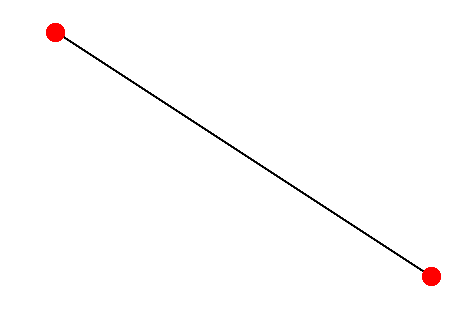

In [7]:
#collapsed code click on the arrow to show the full code --> code returns costprice array 
#Run the model for the overseas supply chain code
for g in range(len(place_array)):
    for j in range(len(carrier_array)):
        for i in range(len(volume1)):
            phi =  51.88121982094231 #latitude of Rotterdam
            lamb = 4.268813386454553 #longitude of Rotterdam

            phirad = phi * np.pi / 180
            lambrad = lamb*np.pi / 180

            theta = 10 #bearing #10
            thetarad = theta * np.pi / 180

            d =  distance #distance array 
            R =  6371 #km earths radius 
            delta = d/R #angular distance 

            import math

            lat2 = math.asin(math.sin(phirad)*math.cos(d/R) + math.cos(phirad)*math.sin(d/R)*math.cos(thetarad))
            phirad2 = lat2
            lon2 = lambrad + math.atan2(math.sin(thetarad)*math.sin(d/R)*math.cos(phirad), 
                                       math.cos(d/R)-math.sin(phirad)*math.sin(phirad2))

            #find longitude and longitude for distance[i]
            londeg = lon2 * 180 / np.pi
            latdeg = lat2 * 180 / np.pi

            path = [(londeg, latdeg), #distance[i]
                    (4.268813386454553,51.88121982094231)] # Botlek NL 

            # convert clicked path to networkx graph and draw
            FG, positions, names = opentisim.core.convert_path_to_graph(path)
            nx.draw(FG, positions)
            FG.nodes

            #define origine and destination 
            origin = shapely.geometry.Point(londeg, latdeg)
            destination = shapely.geometry.Point(4.268813386454553,51.88121982094231)

            # prepare mapping
            mapping = {
                'node-0':'from_site',  # from node
                'node-1':'mid_site',  # mid node 
                      }

            # apply mapping to graph object
            FG = nx.relabel_nodes(FG, mapping)
            FG.nodes

            startyear = startyear_chosen #input
            lifecycle = lifecycle_chosen #input
            years = list(range(startyear, startyear+lifecycle))

            carrier = carrier_array[j] #carrier_chosen #input 
            place = place_array[g] #input
            transport_sc1 = 'vessel'

            if place == 'decentralized':
                sc_export = {'berth_jetty','pipeline_jetty_-_terminal', 'storage', 'h2_conversion'}
                sc_import = {'berth_jetty','pipeline_jetty_-_terminal', 'storage'}
            if place == 'centralized':
                sc_export = {'berth_jetty','pipeline_jetty_-_terminal', 'storage', 'h2_conversion'}
                sc_import = {'berth_jetty','pipeline_jetty_-_terminal', 'storage', 'h2_retrieval'}


            if carrier == 'liquid hydrogen':
                commodity_type_defaults = commodity_lhydrogen_data
                storage_type_defaults = storage_lh2_data
                h2conversion_type_defaults = h2conversion_lh2_data
                h2retrieval_type_defaults = h2retrieval_lh2_data
                vessel_defaults = largehydrogen_data

            if carrier == 'ammonia':
                commodity_type_defaults = commodity_ammonia_data
                storage_type_defaults = storage_nh3_data
                h2conversion_type_defaults = h2conversion_nh3_data
                h2retrieval_type_defaults = h2retrieval_nh3_data
                vessel_defaults = largeammonia_data

            if carrier == 'MCH':
                commodity_type_defaults = commodity_MCH_data
                storage_type_defaults = storage_MCH_data
                h2conversion_type_defaults = h2conversion_MCH_data
                h2retrieval_type_defaults = h2retrieval_MCH_data
                vessel_defaults = vlcc_data

            if carrier == 'DBT':
                commodity_type_defaults = commodity_DBT_data
                storage_type_defaults = storage_DBT_data
                h2conversion_type_defaults = h2conversion_DBT_data
                h2retrieval_type_defaults = h2retrieval_DBT_data
                vessel_defaults = vlcc_data_DBT    

            distancekm, durationdays, maxtrans1, transloss, lossofload,numberoftrips = character_shippingroute1(origin, destination, vessel_defaults)

            #print(distancekm)
            #define losses 
            jetty_loss = jetty_pipeline_data['losses']
            recplant_loss = h2retrieval_type_defaults['losses']
            conplant_loss = h2conversion_type_defaults['losses']
            storage_loss = storage_type_defaults['losses']*30
            transport_loss = transloss 
            Hcontent = commodity_type_defaults['Hcontent']

            total_loss = conplant_loss+storage_loss+jetty_loss +transport_loss+jetty_loss+recplant_loss+storage_loss

            #define demand and supply 
            nx.set_node_attributes(FG, [], 'througput')

            demand_hydrogen1 = volume1[i]
            demand_hydrogen2 = volume2[i]
            demand_hydrogen3 = volume3[i] 

            #volume1 
            if place == 'decentralized':
                 #give the Demand that you need in tonnes of H2 
                demand_carrier1 = (demand_hydrogen1 * 100) / Hcontent #demand is converted to carrier 

                #import terminal is dimensioned on this demand plus losses (import terminal out)
                demand_import_out = demand_carrier1
                demand_import_in = (((jetty_loss+storage_loss)+100)*demand_carrier1)/100

                #export terminal is dimensioned on this demand plus losses (export terminal out)
                demand_export_out = (((transloss+jetty_loss+storage_loss)+100)*demand_carrier1)/100
                demand_export_in = (((conplant_loss + storage_loss + jetty_loss + transloss+jetty_loss+storage_loss)+100)*demand_carrier1)/100

            if place == 'centralized':
                #give the Demand that you need in tonnes of H2 
                demand_carrier1 = (demand_hydrogen1 * 100) / Hcontent #demand is converted to carrier 

                #import terminal is dimensioned on this demand plus losses (import terminal out)
                demand_import_out = demand_carrier1
                demand_import_in = (((jetty_loss+storage_loss+ recplant_loss )+100)*demand_carrier1)/100

                #export terminal is dimensioned on this demand plus losses (export terminal out)
                demand_export_out = (((transloss+jetty_loss+storage_loss + recplant_loss)+100)*demand_carrier1)/100
                demand_export_in = (((conplant_loss + storage_loss + jetty_loss + transloss+jetty_loss+storage_loss + recplant_loss)+100)*demand_carrier1)/100

            #volume2 
            if place == 'decentralized':
                 #give the Demand that you need in tonnes of H2 
                demand_carrier2 = (demand_hydrogen2 * 100) / Hcontent #demand is converted to carrier 

                #import terminal is dimensioned on this demand plus losses (import terminal out)
                demand_import_out2 = demand_carrier2
                demand_import_in2 = (((jetty_loss+storage_loss)+100)*demand_carrier2)/100

                #export terminal is dimensioned on this demand plus losses (export terminal out)
                demand_export_out2 = (((transloss+jetty_loss+storage_loss)+100)*demand_carrier2)/100
                demand_export_in2 = (((conplant_loss + storage_loss + jetty_loss + transloss+jetty_loss+storage_loss)+100)*demand_carrier2)/100

            if place == 'centralized':
                #give the Demand that you need in tonnes of H2 
                demand_carrier2 = (demand_hydrogen2 * 100) / Hcontent #demand is converted to carrier 

                #import terminal is dimensioned on this demand plus losses (import terminal out)
                demand_import_out2 = demand_carrier2
                demand_import_in2 = (((jetty_loss+storage_loss+ recplant_loss )+100)*demand_carrier2)/100

                #export terminal is dimensioned on this demand plus losses (export terminal out)
                demand_export_out2 = (((transloss+jetty_loss+storage_loss + recplant_loss)+100)*demand_carrier2)/100
                demand_export_in2 = (((conplant_loss + storage_loss + jetty_loss + transloss+jetty_loss+storage_loss + recplant_loss)+100)*demand_carrier2)/100

            #volume3 
            if place == 'decentralized':
                 #give the Demand that you need in tonnes of H2 
                demand_carrier3 = (demand_hydrogen3 * 100) / Hcontent #demand is converted to carrier 

                #import terminal is dimensioned on this demand plus losses (import terminal out)
                demand_import_out3 = demand_carrier3
                demand_import_in3 = (((jetty_loss+storage_loss)+100)*demand_carrier3)/100

                #export terminal is dimensioned on this demand plus losses (export terminal out)
                demand_export_out3 = (((transloss+jetty_loss+storage_loss)+100)*demand_carrier3)/100
                demand_export_in3 = (((conplant_loss + storage_loss + jetty_loss + transloss+jetty_loss+storage_loss)+100)*demand_carrier3)/100

            if place == 'centralized':
                #give the Demand that you need in tonnes of H2 
                demand_carrier3 = (demand_hydrogen3 * 100) / Hcontent #demand is converted to carrier 

                #import terminal is dimensioned on this demand plus losses (import terminal out)
                demand_import_out3 = demand_carrier3
                demand_import_in3 = (((jetty_loss+storage_loss+ recplant_loss )+100)*demand_carrier3)/100

                #export terminal is dimensioned on this demand plus losses (export terminal out)
                demand_export_out3 = (((transloss+jetty_loss+storage_loss + recplant_loss)+100)*demand_carrier3)/100
                demand_export_in3 = (((conplant_loss + storage_loss + jetty_loss + transloss+jetty_loss+storage_loss + recplant_loss)+100)*demand_carrier3)/100

            # create a supply at the from_site
            supply = []
            for year in years:
                if year >= 2020 and year < 2030:
                    supply.append(demand_export_out)
                elif year >= 2030 and year <2040:
                    supply.append(demand_export_out2)
                else:
                    supply.append(demand_export_out3)

            throughput_from = pd.DataFrame({'year': years, 
                                 'volume': supply})
            FG.nodes['from_site']['througput'] = throughput_from

            # create a demand at the mid_site
            demand = []
            for year in years:
                if year >= 2020 and year < 2030:
                    demand.append(demand_import_out)
                elif year >= 2030 and year <2040:
                    demand.append(demand_import_out2)
                else:
                    demand.append(demand_import_out3)

            throughput_mid = pd.DataFrame({'year': years, 
                                 'volume': demand})
            FG.nodes['mid_site']['througput'] = throughput_mid
            #print(throughput_mid)

            # add an empty terminal property
            nx.set_node_attributes(FG, [], 'terminal')

            # add an empty OpenCLSim Site property
            nx.set_node_attributes(FG, [], 'site')

            if carrier == 'liquid hydrogen':
                commodity_lhydrogen_data['smallhydrogen_perc'] = 0
                commodity_lhydrogen_data['largehydrogen_perc'] = 100
                commodity_lhydrogen_data['historic_data'] = []
                commodity_lhydrogen_data['scenario_data'] = []
                lhydrogen = Commodity(**commodity_lhydrogen_data)
                lhydrogen.scenario_data = throughput_from
                demand = [lhydrogen] 

            if carrier == 'ammonia':
                commodity_ammonia_data["smallammonia_perc"] = 0
                commodity_ammonia_data["largeammonia_perc"] = 100
                commodity_ammonia_data['historic_data'] = []
                commodity_ammonia_data['scenario_data'] = []
                ammonia = Commodity(**commodity_ammonia_data)
                ammonia.scenario_data = throughput_from  #choose what carrier
                demand = [ammonia] 

            if carrier == 'MCH':
                commodity_MCH_data["handysize_perc"] = 0
                commodity_MCH_data["panamax_perc"] = 0
                commodity_MCH_data["vlcc_perc"] = 100
                commodity_MCH_data['historic_data'] = []
                commodity_MCH_data['scenario_data'] = []
                MCH = Commodity(**commodity_MCH_data)
                MCH.scenario_data = throughput_from  #choose what carrier
                demand = [MCH] 

            if carrier == 'DBT':
                commodity_DBT_data["handysize_perc"] = 0
                commodity_DBT_data["panamax_perc"] = 0
                commodity_DBT_data["vlcc_perc"] = 100
                commodity_DBT_data['historic_data'] = []
                commodity_DBT_data['scenario_data'] = []
                DBT = Commodity(**commodity_DBT_data)
                DBT.scenario_data = throughput_from  #choose what carrier
                demand = [DBT] 

            # instantiate vessels
            Smallhydrogen = Vessel(**smallhydrogen_data)
            Largehydrogen = Vessel(**largehydrogen_data)
            Smallammonia = Vessel(**smallammonia_data)
            Largeammonia = Vessel(**largeammonia_data)
            Handysize = Vessel(**handysize_data)
            Panamax = Vessel(**panamax_data)

            if carrier == 'MCH':
                VLCC = Vessel(**vlcc_data)
            elif carrier == 'DBT':
                VLCC = Vessel(**vlcc_data_DBT)
            else:
                VLCC = Vessel(**vlcc_data)

            # vessels variable: contains info on vessels (to be added to Terminal.elements)
            vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC]


            if carrier == 'MCH' or carrier == 'DBT':
                dwelltime = 30/365
            if carrier == 'liquid hydrogen':
                dwelltime = 15/365
            else:
                dwelltime = 30/365

            # Instantiate OpenTISim Terminal
            from_site_terminal = opentisim.liquidbulk.ExportTerminal(
                        startyear = None, 
                        lifecycle = 1, 
                        distance = distancekm, 
                        elements = demand + vessels, 
                        operational_hours = 16*365,   # example Wijnand
                        terminal_supply_chain=sc_export,
                        debug=False,
                        commodity_type_defaults=commodity_type_defaults,
                        storage_type_defaults=storage_type_defaults,
                        kendall='E2/E2/n',
                        allowable_waiting_service_time_ratio_berth=0.3,
                        h2conversion_type_defaults=h2conversion_type_defaults,
                        allowable_dwelltime= dwelltime)

            from_site_terminal.modelframe = list(range(startyear, startyear + lifecycle))
            from_site_terminal.revenues = []
            from_site_terminal.demurrage = []

            # add an OpenTNSim Terminal to the graph
            FG.nodes['from_site']['terminal'] = from_site_terminal

            if carrier == 'liquid hydrogen':
                commodity_lhydrogen_data['smallhydrogen_perc'] = 0
                commodity_lhydrogen_data['largehydrogen_perc'] = 100
                commodity_lhydrogen_data['historic_data'] = []
                commodity_lhydrogen_data['scenario_data'] = []
                lhydrogen = Commodity(**commodity_lhydrogen_data)
                lhydrogen.scenario_data = throughput_mid
                demand = [lhydrogen] 

            if carrier == 'ammonia':
                commodity_ammonia_data["smallammonia_perc"] = 0
                commodity_ammonia_data["largeammonia_perc"] = 100
                commodity_ammonia_data['historic_data'] = []
                commodity_ammonia_data['scenario_data'] = []
                ammonia = Commodity(**commodity_ammonia_data)
                ammonia.scenario_data = throughput_mid  #choose what carrier
                demand = [ammonia] 

            if carrier == 'MCH':
                commodity_MCH_data["handysize_perc"] = 0
                commodity_MCH_data["panamax_perc"] = 0
                commodity_MCH_data["vlcc_perc"] = 100
                commodity_MCH_data['historic_data'] = []
                commodity_MCH_data['scenario_data'] = []
                MCH = Commodity(**commodity_MCH_data)
                MCH.scenario_data = throughput_mid  #choose what carrier
                demand = [MCH] 


            if carrier == 'DBT':
                commodity_DBT_data["handysize_perc"] = 0
                commodity_DBT_data["panamax_perc"] = 0
                commodity_DBT_data["vlcc_perc"] = 100
                commodity_DBT_data['historic_data'] = []
                commodity_DBT_data['scenario_data'] = []
                DBT = Commodity(**commodity_DBT_data)
                DBT.scenario_data = throughput_mid  #choose what carrier
                demand = [DBT] 

            # instantiate vessels
            Smallhydrogen = Vessel(**smallhydrogen_data)
            Largehydrogen = Vessel(**largehydrogen_data)
            Smallammonia = Vessel(**smallammonia_data)
            Largeammonia = Vessel(**largeammonia_data)
            Handysize = Vessel(**handysize_data)
            Panamax = Vessel(**panamax_data)

            if carrier == 'MCH':
                VLCC = Vessel(**vlcc_data)
            elif carrier == 'DBT':
                VLCC = Vessel(**vlcc_data_DBT)
            else:
                VLCC = Vessel(**vlcc_data)

            # vessels variable: contains info on vessels (to be added to Terminal.elements)
            vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC]


            if carrier == 'MCH' or carrier == 'DBT':
                dwelltime = 30/365
            if carrier == 'liquid hydrogen':
                dwelltime = 15/365
            else:
                dwelltime = 30/365

            # Instantiate OpenTNSim Terminal
            mid_site_terminal =  opentisim.liquidbulk.System(
                        startyear = None, 
                        lifecycle = 1, 
                        elements = demand + vessels, 
                        operational_hours = 16*365,   # example Wijnand
                        terminal_supply_chain=sc_import,
                        debug=False,
                        commodity_type_defaults=commodity_type_defaults,
                        storage_type_defaults=storage_type_defaults,
                        kendall='E2/E2/n',
                        allowable_waiting_service_time_ratio_berth=0.3,
                        h2retrieval_type_defaults=h2retrieval_type_defaults,
                        allowable_dwelltime= dwelltime)


            mid_site_terminal.modelframe = list(range(startyear, startyear + lifecycle))
            mid_site_terminal.revenues = []
            mid_site_terminal.demurrage = []

            # add an OpenTNSim Terminal to the graph
            #FG.nodes['from_site']['terminal'] = from_site_terminal

            # add an OpenTNSim Terminal to the graph
            FG.nodes['mid_site']['terminal'] = mid_site_terminal

            supplychain_1 = SupplyChain(
                name='Supplychain 1',
                elements = [],
                origin = 'from_site',
                origin_latent_demand = 0,
                origin_online_throughput = 0,
                destination='mid_site',
                destination_latent_demand = 0,
                destination_online_throughput = 0,
                condition=[{"type": "container", "concept": 'from_site', "state": "empty"}],
                capacity=None)

            supplychains = [supplychain_1]

            #define ship characteristics 
            capacity_ship = vessel_defaults["call_size"]
            pump_ship = vessel_defaults["pump_capacity"]
            loadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
            unloadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
            velocity_ship = vessel_defaults['avspeed']/3.6 # #25 km/h --> m/s 
            losses_ship = vessel_defaults['losses']

            if carrier == 'MCH' or carrier == 'DBT':
                loadingtime_ship = 2*loadingtime_ship
                unloadingtime_ship = 2*unloadingtime_ship

            #define what to print
            Debug = False
            debug = False

            #create empty dataframes 
            commodity_lhydrogen_data['scenario_data'] = []
            commodity_ammonia_data['scenario_data'] = []
            commodity_MCH_data['scenario_data'] = []
            dataframe_openclsim = []

            startyear = startyear_chosen
            lifecycle = lifecycle_chosen 

            years = list(range(startyear, startyear+lifecycle))
            years1 =  list(range(startyear, startyear+lifecycle))
            years2 = list(range(startyear+2,startyear+lifecycle))

            for index_year,year in enumerate(years):
                for supplychain in supplychains:
                    count_vessel = 0 
                    FG.nodes[supplychain.origin]['site'] = []
                    FG.nodes[supplychain.destination]['site'] = []
                # OpenTISim: op 1 januari neem je al je beslissingen (terminals + supply chains)
                if debug == True:
                    print('')
                    print('simulation for year: {} ---------------'.format(year))

                for supplychain in supplychains:
                    # 1. als de origin node in de supplychain een throughput property heeft, 
                    # bereken dan de benodigde terminal dimensies
                    throughput_online_origin = 0
                    if type(FG.nodes[supplychain.origin]['througput']) == pd.core.frame.DataFrame:
                        FG.nodes[supplychain.origin]['terminal'].startyear = year
                        FG.nodes[supplychain.origin]['terminal'].debug = Debug
                        #FG.nodes[supplychain.origin]['terminal'].years = years1
                        #print(FG.nodes[supplychain.origin]['terminal'].__dict__)
                        FG.nodes[supplychain.origin]['terminal'].simulate()

                        throughput_online_origin, throughput_terminal_in,throughput_online_jetty_in, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  FG.nodes[supplychain.origin]['terminal'].throughput_elements(year)

                        if debug == True:
                            print('Terminal: {}, year: {}, throughput online: {}'.format(supplychain.origin, year, throughput_online_origin))
                            print('')
                            print()

                        #supplychain.origin_online_throughput = throughput_online_jetty_origin
                        supplychain.origin_online_throughput = throughput_online_origin

                     # 2. als de destination node in de supplychain een throughput property heeft, 
                    # bereken dan de benodigde terminal dimensies
                    throughput_online_destination = 0
                    if type(FG.nodes[supplychain.destination]['througput']) == pd.core.frame.DataFrame:

                        FG.nodes[supplychain.destination]['terminal'].startyear = year
                        FG.nodes[supplychain.destination]['terminal'].debug = Debug
                        #FG.nodes[supplychain.destination]['terminal'].years = years1
                        FG.nodes[supplychain.destination]['terminal'].simulate()

                        throughput_online_destination, throughput_terminal_in,throughput_online_jetty_in_dest, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  = FG.nodes[supplychain.destination]['terminal'].throughput_elements(year)

                        if debug == True:
                            print('Terminal: {}, year: {}, throughput: {}'.format(supplychain.destination, year, throughput_online_destination))
                            print('')

                        supplychain.destination_online_throughput = throughput_online_jetty_in_dest

                    # 3. als de origin een throughput heeft, maar de destination niet,
                    # voeg dan de throughput van de origin toe aan die van de destination 
                    if throughput_online_origin != 0 and throughput_online_destination == 0:
                        if debug == True:
                            print('The origin is generating throughput. I need a latent demand in the destination location.')

            #             The origin is generating throughput. I need a latent demand in the destination location.
            #             Terminal: mid_site, year: 2004, throughput: 1617850.649350649

                        #supplychain.destination_latent_demand = throughput_online_jetty_origin
                        supplychain.destination_latent_demand = throughput_online_origin

                        # Use the throughput at the other end of the supply chain as a latent demand

                        # Liquid hydrogen
                        if carrier == 'liquid hydrogen':
                            commodity_lhydrogen_data['historic_data'] = []
                            lhydrogen = Commodity(**commodity_lhydrogen_data)
                            lhydrogen.scenario_data.append({'year': year, 'volume': throughput_online_jetty_origin})
                            lhydrogen.scenario_data = pd.DataFrame(lhydrogen.scenario_data)
                            demand = [lhydrogen]
                            #print(lhydrogen.scenario_data)


                        # Ammonia
                        if carrier == 'ammonia':
                            commodity_ammonia_data['historic_data'] = []
                            ammonia = Commodity(**commodity_ammonia_data)
                            ammonia.scenario_data.append({'year': year, 'volume': throughput_online_jetty_origin})
                            ammonia.scenario_data = pd.DataFrame(ammonia.scenario_data)
                            demand = [ammonia]

                        # MCH
                        if carrier == 'MCH': 
                            commodity_MCH_data['historic_data'] = []
                            MCH = Commodity(**commodity_MCH_data)
                            MCH.scenario_data.append({'year': year, 'volume': throughput_online_jetty_origin})
                            MCH.scenario_data = pd.DataFrame(MCH.scenario_data)
                            demand = [MCH]

                        if carrier == 'DBT': 
                            commodity_DBT_data['historic_data'] = []
                            DBT = Commodity(**commodity_DBT_data)
                            DBT.scenario_data.append({'year': year, 'volume': throughput_online_jetty_origin})
                            DBT.scenario_data = pd.DataFrame(DBT.scenario_data)
                            demand = [DBT]


                        # adopt vessels from the other node
                        vessels = [x for x in FG.nodes[supplychain.origin]['terminal'].elements if type(x) == Vessel]

                        # find all terminal_elements that are NOT a commodity
                        terminal_elements = [x for x in FG.nodes[supplychain.destination]['terminal'].elements if type(x) != Commodity and type(x) != Vessel]

                        # add terminal_elements + new demands
                        FG.nodes[supplychain.destination]['terminal'].elements = terminal_elements + demand + vessels

                        FG.nodes[supplychain.destination]['terminal'].startyear = year
                        FG.nodes[supplychain.destination]['terminal'].debug = Debug
                        FG.nodes[supplychain.destination]['terminal'].years = years2
                        FG.nodes[supplychain.destination]['terminal'].simulate()

                        throughput_online_destination, throughput_terminal_in,throughput_online_jetty_in_dest, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  FG.nodes[supplychain.destination]['terminal'].throughput_elements(year)

                        if debug == True:
                            print('Terminal: {}, year: {}, throughput: {}'.format(supplychain.destination, year, throughput_online_jetty_destination))
                            print('')

                        #supplychain.destination_online_throughput = throughput_online_jetty_destination
                        supplychain.destination_online_throughput = throughput_online_jetty_in_dest


                    # 4. als de origin geen throughput heeft, maar de destination wel,
                    # voeg dan de throughput van de destination toe aan die van de origin 
                    if throughput_online_origin == 0 and throughput_online_destination != 0:
                        if debug == True:
                            print('The destination is generating throughput. I need latent demand in the origin location')

                        supplychain.origin_latent_demand = throughput_online_jetty_in_dest #throughput_online_jetty_destination

                        # Use the throughput at the other end of the supply chain as a latent demand
                        supply = list(np.matlib.repmat(throughput_online_jetty_destination,1,1)[0])
                        througput_origin = pd.DataFrame({'year': year, 'volume': supply})

                        # Liquid hydrogen
                        if carrier == 'liquid hydrogen':
                            commodity_lhydrogen_data['historic_data'] = []
                            #lhydrogen = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_lhydrogen_data)

                            if lhydrogen.scenario_data['volume'].values[-1] > throughput_online_jetty_destination:
                                lhydrogen.scenario_data = lhydrogen.scenario_data
                                #print('true')
                            else:
                                lhydrogen.scenario_data.append({'year': year, 'volume': throughput_online_jetty_destination}) #xxx
                                lhydrogen.scenario_data = pd.DataFrame(lhydrogen.scenario_data)
                                #print('false')
                            demand = [lhydrogen]

                        if carrier == 'ammonia':
                            commodity_ammonia_data['historic_data'] = []
                            if ammonia.scenario_data['volume'].values[-1] > throughput_online_jetty_destination:
                                ammonia.scenario_data = ammonia.scenario_data
                                #print('true')
                            else:
                                ammonia.scenario_data.append({'year': year, 'volume': throughput_online_jetty_destination}) #xxx
                                ammonia.scenario_data = pd.DataFrame(ammonia.scenario_data)
                                #print('false')
                            demand = [ammonia]

                        if carrier == 'MCH':
                            commodity_MCH_data['historic_data'] = []
                            if MCH.scenario_data['volume'].values[-1] > throughput_online_jetty_destination:
                                MCH.scenario_data = MCH.scenario_data
                                #print('true')
                            else:
                                MCH.scenario_data.append({'year': year, 'volume': throughput_online_jetty_destination}) #xxx
                                MCH.scenario_data = pd.DataFrame(MCH.scenario_data)
                                #print('false')
                            demand = [MCH]

                        if carrier == 'DBT':
                            commodity_DBT_data['historic_data'] = []
                            if DBT.scenario_data['volume'].values[-1] > throughput_online_jetty_destination:
                                DBT.scenario_data = DBT.scenario_data
                                #print('true')
                            else:
                                DBT.scenario_data.append({'year': year, 'volume': throughput_online_jetty_destination}) #xxx
                                DBT.scenario_data = pd.DataFrame(DBT.scenario_data)
                                #print('false')
                            demand = [DBT]

                        # adopt vessels from the other node
                        vessels = [x for x in FG.nodes[supplychain.destination]['terminal'].elements if type(x) == Vessel]

                        # find all terminal_elements that are NOT a commodity
                        terminal_elements = [x for x in FG.nodes[supplychain.origin]['terminal'].elements if type(x) != Commodity and type(x) != Vessel]

                        # add terminal_elements + new demands
                        FG.nodes[supplychain.origin]['terminal'].elements = terminal_elements + demand + vessels

                        FG.nodes[supplychain.origin]['terminal'].startyear = year
                        FG.nodes[supplychain.origin]['terminal'].debug = Debug
                        FG.nodes[supplychain.origin]['terminal'].years = years2
                        FG.nodes[supplychain.origin]['terminal'].simulate()

                        throughput_online_origin, throughput_terminal_in,throughput_online_jetty_in, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  = FG.nodes[supplychain.origin]['terminal'].throughput_elements(year)

                        if debug == True:
                            print('Terminal: {}, year: {}, throughput: {}'.format(supplychain.origin, year, throughput_online_jetty_origin))
                            print('')

                        supplychain.origin_online_throughput = throughput_online_origin

                # 5. run openclsim calculation
                # OpenCLSim: tussen 2 januari - 31 december ga je transporteren
                if supplychain.origin_online_throughput !=0 and supplychain.destination_online_throughput!=0:

                    # step past all supplychains to initiate the sites and vessels
                    for index, supplychain in enumerate(supplychains):

                        if index == 0:
                            #level_from_site = min([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                            level_from_site = supplychain.origin_online_throughput
                            level_to_site = 0
                            #activities = []
                            while level_from_site != 0:
                                count_vessel += 1
                                if debug == True:
                                    print('**Add a ship**')
                                #make environment 
                                #simulation_start  = datetime.datetime(year, 1, 1, 0, 0)
                                #my_env = simpy.Environment(initial_time=simulation_start.timestamp())
                                simulation_start = 0 
                                my_env = simpy.Environment(initial_time=simulation_start)


                                # origin
                                capacity_from_site = max([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                                #level_from_site = min([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                                data_from_site = {"env": my_env,
                                             "name": supplychain.origin,
                                             "geometry": FG.nodes[supplychain.origin]['geometry'],
                                             "capacity": capacity_from_site, 
                                             "level": level_from_site
                                             }
                                FG.nodes[supplychain.origin]['site'] = Site(**data_from_site)
                                from_site = Site(**data_from_site)


                                # destination
                                capacity_to_site = capacity_from_site #max([supplychain.destination_online_throughput, supplychain.origin_latent_demand])
                                #level_to_site = min([supplychain.destination_online_throughput, supplychain.origin_latent_demand])
                                data_to_site = {"env": my_env,
                                             "name": supplychain.destination,
                                             "geometry": FG.nodes[supplychain.destination]['geometry'],
                                             "capacity": capacity_to_site, 
                                             "level": level_to_site #0
                                             }
                                FG.nodes[supplychain.destination]['site'] = Site(**data_to_site)
                                to_site = Site(**data_to_site)
                                capacity_bog = capacity_to_site

                                boil_off_container = {"env": my_env,
                                             "name": 'boil-off',
                                              "geometry": FG.nodes[supplychain.destination]['geometry'],
                                              #"loading_rate": 0.00001,
                                             #"unloading_rate": 0.00001,
                                             "capacity": capacity_bog, 
                                              "compute_v": lambda x: 0
                                            }


                                boil_off01 = BoiloffResource(**boil_off_container)

                                if debug == True:
                                    print('capacity at origin', capacity_from_site)
                                    print('level at origin', level_from_site)
                                    print('capacity at destination', capacity_to_site)
                                    print('level at destination', level_to_site)

                                # vessels
                                # prepare input data for vessel_01
                                data_vessel01 = {"env": my_env,
                                                 "name": "vessel " + supplychain.name,
                                                 "geometry": FG.nodes[supplychain.origin]['geometry'], 
                                                 "loading_rate": 0.00001,
                                                 "unloading_rate": 0.00001,
                                                 "capacity": capacity_ship,
                                                 "compute_v": lambda x: velocity_ship
                                                }


                                # instantiate vessel_01 
                                vessel01 = TransportProcessingResource(**data_vessel01)

                                supplychain.elements = [vessel01]

                                # use the sites from the graph and the vessels from the supplychains to construct activities
                                #activities = []

                                # initialise registry
                                registry = {}
                                if debug == True:
                                    print('transporter activity between from_site and mid_site')

                                # create a list of the sub processes
                                requested_resources1 = {}

                                sub_processes = [
                                    openclsim.model.MoveActivity(
                                        env=my_env,
                                        name="sailing empty",
                                        registry=registry,
                                        mover=vessel01,
                                        destination=from_site,
                                        requested_resources=requested_resources1,
                                    ),
                                    openclsim.model.ShiftAmountActivity(
                                        env=my_env,
                                        name="loading",
                                        registry=registry,
                                        processor=vessel01,
                                        origin=from_site,
                                        destination=vessel01,
                                        amount=capacity_ship,
                                        duration=loadingtime_ship,
                                        requested_resources=requested_resources1,
                                    ),
                                    openclsim.model.MoveActivity(
                                        env=my_env,
                                        name="sailing full",
                                        registry=registry,
                                        mover=vessel01,
                                        destination=to_site,
                                        requested_resources=requested_resources1,
                                    ),
                                    openclsim.model.ShiftAmountActivity(
                                        env=my_env,
                                        name="boil off",
                                        registry=registry,
                                        processor=vessel01,
                                        origin=vessel01,
                                        destination=boil_off01,
                                        amount=lossofload,
                                        duration=0,
                                        requested_resources=requested_resources1,
                                    ),
                                    openclsim.model.ShiftAmountActivity(
                                        env=my_env,
                                        name="unloading",
                                        registry=registry,
                                        processor=vessel01,
                                        origin=vessel01,
                                        destination=to_site,
                                        amount=capacity_ship,
                                        duration=unloadingtime_ship, #in seconds 
                                        requested_resources=requested_resources1,
                                    ),
                                    openclsim.model.BasicActivity(
                                        env=my_env,
                                        name="basic activity",
                                        registry=registry,
                                        duration=0,
                                        additional_logs=[vessel01],
                                        requested_resources=requested_resources1,
                                    ),
                                ]

                                # create a 'sequential activity' that is made up of the 'sub_processes'
                                sequential_activity = openclsim.model.SequentialActivity(
                                    env=my_env,
                                    name="sequential_activity_subcycle_1",
                                    registry=registry,
                                    sub_processes=sub_processes,
                                )

                                #print(sub_processes[3])

                                # now the site has been created we can add the site variable to the condition
                                if level_from_site > maxtrans1:#1019700:
                                    #print('yes')
                                    condition = [{"type": "activity", "name": "while_sequential_activity_subcycle ", "state": "done"}]

                                    while_activity = openclsim.model.WhileActivity(
                                        env=my_env,
                                        name="while_sequential_activity_subcycle ", #+ supplychain.name,
                                        registry=registry,
                                        sub_processes=[sequential_activity],
                                        condition_event=condition,
                                    )

                                    model.register_processes([while_activity])
                                    secyear = 60*60*24*365
                                    my_env.run(until = secyear)
                                else:
                                    #print('no')
                                    condition1 = [{"type": "container", "concept": from_site, "state": "empty"}]
                                    sub_processes_new = sub_processes.pop(3)

                                    sequential_activity = openclsim.model.SequentialActivity(
                                        env=my_env,
                                        name="sequential_activity_subcycle_1",
                                        registry=registry,
                                        sub_processes=sub_processes,
                                    )


                                    while_activity = openclsim.model.WhileActivity(
                                        env=my_env,
                                        name="while_sequential_activity_subcycle ", #+ supplychain.name,
                                        registry=registry,
                                        sub_processes=[sequential_activity],
                                        condition_event=condition1,
                                    )

                                    model.register_processes([while_activity])
                                    my_env.run()
                                    #condition = [{"type": vessel01, "concept": from_site, "state": "empty"}]

                                df1 = plot.get_log_dataframe(from_site, [while_activity, *sub_processes])
                                level_from_site = df1['container level'].values[-1]

                                df2 = plot.get_log_dataframe(to_site, [while_activity, *sub_processes])
                                level_to_site = df2['container level'].values[-1]

                                df4 = plot.get_log_dataframe(vessel01, [while_activity, *sub_processes])

                                if level_from_site > maxtrans1:
                                    df3 = plot.get_log_dataframe(boil_off01, [while_activity, *sub_processes])

                                    if df4['container level'].values[-1] != 0:
                                        level_boil_off = df3['container level'].values[-1] + lossofload 
                                    else: 
                                        level_boil_off = df3['container level'].values[-1] 


                                    level_vessel = df4['container level'].values[-1]
                                        #level_vessel = 0 #vessel is emptied 

                                if df4['container level'].values[-1] != 0:
                                    new = df2['container level'].values[-1] + (df4['container level'].values[-1]-lossofload)
                                else: 
                                    new = df2['container level'].values[-1] + df4['container level'].values[-1]

                                level_to_site = new

                                if debug == True:
                                            print(
                                                '     a total of {} ton of hydrogen is at the origin'.format(
                                                    level_from_site))

            #                                 print(
            #                                     '     a total of {} ton of hydrogen is at boil-off'.format(
            #                                         level_boil_off ))
            #                                 print(
            #                                     '     a total of {} ton of hydrogen is at vessel'.format(
            #                                         level_vessel ))
                                            print(
                                                '     a total of {} ton of hydrogen is at the destination when last vessel is emptied'.format(
                                                    level_to_site))


                            dataframe_openclsim.append({'year': year,'level to site': level_to_site, 'vessel count':count_vessel,})

            #define dataframe with openclsim informations
            df_openclsim = pd.DataFrame(dataframe_openclsim)

            #define import terminal 
            node = 'mid_site'
            FG.nodes[node]['terminal'].years = years
            importterminal = FG.nodes[node]['terminal']

            labour = Labour(**labour_data)
            cash_flows_importterminal, cash_flows_WACC_real_importterminal = opentisim.core.add_cashflow_elements(importterminal, labour)

            #define export terminal 
            node = 'from_site'
            FG.nodes[node]['terminal'].years = years
            exportterminal = FG.nodes[node]['terminal']

            labour = Labour(**labour_data)
            cash_flows_exportterminal, cash_flows_WACC_real_exportterminal = opentisim.core.add_cashflow_elements(exportterminal, labour)

            #define transport between export and import terminal
            dataframe_vessel = df_openclsim
            seaborne_transport = vessel_objects(exportterminal, dataframe_vessel, vessel_defaults, durationdays, numberoftrips)
            cash_flows_seatransport,cash_flows_WACC_real_seatransport = add_cashflow_vessels(exportterminal, seaborne_transport)


            #define costprice
            costprice_kgH2_WACC, costprice_kgCAR, costprice_import_WACC, costprice_transport_WACC,costprice_export_WACC = costprice_supplychain1(years,Hcontent, cash_flows_WACC_real_importterminal,cash_flows_WACC_real_exportterminal,cash_flows_WACC_real_seatransport)

            if place == 'centralized':
                print(costprice_kgH2_WACC)
                costpricearray[i] = costprice_kgH2_WACC
                save_costprice[j][i] = costpricearray[i]
            if place == 'decentralized':
                print(costprice_kgCAR)
                costpricearray2[i] = costprice_kgCAR
                save_costprice2[j][i] = costpricearray2[i]
    
    save_options[g][0] = save_costprice2

In [8]:
# print('centralized')
# print(save_costprice)
# print('decentralized')
# print(save_costprice2)
#print(save_costprice[0][2])
#print(list(costpricearray))

costpricearray3 = np.zeros(len(volume1))
costpricearray4 = np.zeros(len(volume1))
save_costprice3 = np.empty([carrier_count, distance_count],dtype=object)
save_costprice4 = np.empty([carrier_count, distance_count],dtype=object)

## 4. Run the model for the supply chain to the hinterland

In [9]:
#costpride code
def costprice_supplychains2(price, WACC,commodity_type_defaults, exportterminal, importterminal, enduse, inland_transport, seaborne_transport, labour):
    if importterminal.place == 'centralized':
        
        Hcontent = commodity_type_defaults['Hcontent']
        
        cash_flows_seatransport,cash_flows_WACC_real_seatransport = add_cashflow_vessels(exportterminal,seaborne_transport)
        cash_flows_transport,cash_flows_WACC_real_transport = add_cashflow_pipe(importterminal, inland_transport)
        cash_flows_exportterminal, cash_flows_WACC_real_exportterminal = opentisim.core.add_cashflow_elements(exportterminal, labour)
        cash_flows_importterminal, cash_flows_WACC_real_importterminal= opentisim.core.add_cashflow_elements(importterminal, labour)
        cash_flows_endterminal, cash_flows_WACC_real_endterminal= opentisim.core.add_cashflow_elements(enduse, labour)

        if WACC == 'on':
            cash_flows_importterminal = cash_flows_WACC_real_importterminal
            cash_flows_exportterminal = cash_flows_WACC_real_exportterminal
            cash_flows_seatransport =cash_flows_WACC_real_seatransport
            cash_flows_endterminal = cash_flows_WACC_real_endterminal
            cash_flows_transport = cash_flows_WACC_real_transport 
        if WACC == 'off':
            cash_flows_importterminal = cash_flows_importterminal
            cash_flows_exportterminal =cash_flows_exportterminal
            cash_flows_seatransport =cash_flows_seatransport
            cash_flows_endterminal =cash_flows_endterminal
            cash_flows_transport = cash_flows_transport

        throughputsum = 0
        for year in enduse.years:
            throughput_online_end, throughput_terminal_in_end ,throughput_online_jetty_in_end, throughput_online_stor_in_end, throughput_online_plant_in_end, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  enduse.throughput_elements(year)
            throughputsum += throughput_online_end

        throughputsum_kg = throughputsum*1000
        throughputsum_kg_H2 = (throughputsum_kg *Hcontent)/100

        capex_import = cash_flows_importterminal['capex']+cash_flows_importterminal['capex_material']
        capex_export = cash_flows_exportterminal['capex']+cash_flows_exportterminal['capex_material']
        capex_transport_sc1 = cash_flows_seatransport['capex'] 
        capex_enduse = cash_flows_endterminal['capex']+cash_flows_endterminal['capex_material']
        capex_transport_sc2 = cash_flows_transport['capex'] 

        capex_tot =  capex_import + capex_export + capex_transport_sc1 + capex_enduse + capex_transport_sc2
        capex_end =  capex_transport_sc2


        opex_import = cash_flows_importterminal['maintenance']+cash_flows_importterminal['insurance'] + cash_flows_importterminal['energy']+ \
                    cash_flows_importterminal['labour'] + cash_flows_importterminal['fuel']+cash_flows_importterminal['purchaseH2']+\
                    cash_flows_importterminal['purchase_material']

        opex_export = cash_flows_exportterminal['maintenance']+cash_flows_exportterminal['insurance'] + cash_flows_exportterminal['energy']+ \
                    cash_flows_exportterminal['labour'] + cash_flows_exportterminal['fuel']+cash_flows_exportterminal['purchaseH2']+\
                    cash_flows_exportterminal['purchase_material']

        opex_enduse = cash_flows_endterminal['maintenance']+cash_flows_endterminal['insurance'] + cash_flows_endterminal['energy']+ \
                    cash_flows_endterminal['labour'] + cash_flows_endterminal['fuel']+cash_flows_endterminal['purchaseH2']+\
                    cash_flows_endterminal['purchase_material']

        opex_transport_sc1 = cash_flows_seatransport['maintenance']+cash_flows_seatransport['insurance'] + \
                    cash_flows_seatransport['labour'] + cash_flows_seatransport['fuel']

        opex_transport_sc2 = cash_flows_transport['maintenance']+cash_flows_transport['insurance'] + \
                    cash_flows_transport['labour'] + cash_flows_transport['energy']

        opex_tot = opex_import + opex_export + opex_transport_sc1  + opex_enduse + opex_transport_sc2
        opex_end = opex_transport_sc2

        throughputsum_term_out = 0
        for year in enduse.years:
            throughput_online_end, throughput_terminal_in_end ,throughput_online_jetty_in_end, throughput_online_stor_in_end, throughput_online_plant_in_end, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  importterminal.throughput_elements(year)
            throughputsum_term_out += throughput_online_end

        throughputsum_kg_im = throughputsum_term_out*1000
        throughputsum_kg_H2_im = (throughputsum_kg_im *Hcontent)/100

        opex_new = price * throughputsum_kg_H2_im 
        print(price,throughputsum_kg_H2_im , opex_new )

        costs_tot = capex_tot + opex_tot 

        cost_end = sum(capex_end) + sum(opex_end) + opex_new

        sum_costs_tot = sum(costs_tot)

        costprice_kgH2 = sum_costs_tot / throughputsum_kg_H2

        costprice_kgH2_new = cost_end / throughputsum_kg_H2

        costprice_import = sum(capex_import+opex_import)/ throughputsum_kg_H2
        costprice_transport_sc1 = sum(capex_transport_sc1+opex_transport_sc1)/ throughputsum_kg_H2
        costprice_export = sum(capex_export+opex_export)/ throughputsum_kg_H2
        costprice_enduse = sum(capex_enduse+opex_enduse)/ throughputsum_kg_H2
        costprice_transport_sc2 = sum(capex_transport_sc2+opex_transport_sc2)/ throughputsum_kg_H2

        return costprice_kgH2_new, costprice_kgH2, costprice_import, costprice_transport_sc1,costprice_export, costprice_enduse, costprice_transport_sc2

    if importterminal.place == 'decentralized':
        
        Hcontent = commodity_type_defaults['Hcontent']

        cash_flows_seatransport,cash_flows_WACC_real_seatransport = add_cashflow_vessels(exportterminal,seaborne_transport)
        cash_flows_transport,cash_flows_WACC_real_transport = add_cashflow_vessels(importterminal, inland_transport)
        cash_flows_exportterminal, cash_flows_WACC_real_exportterminal = opentisim.core.add_cashflow_elements(exportterminal, labour)
        cash_flows_importterminal, cash_flows_WACC_real_importterminal= opentisim.core.add_cashflow_elements(importterminal, labour)
        cash_flows_endterminal, cash_flows_WACC_real_endterminal= opentisim.core.add_cashflow_elements(enduse, labour)

        if WACC == 'on':
            cash_flows_importterminal = cash_flows_WACC_real_importterminal
            cash_flows_exportterminal = cash_flows_WACC_real_exportterminal
            cash_flows_seatransport =cash_flows_WACC_real_seatransport
            cash_flows_endterminal = cash_flows_WACC_real_endterminal
            cash_flows_transport = cash_flows_WACC_real_transport 
        if WACC == 'off':
            cash_flows_importterminal = cash_flows_importterminal
            cash_flows_exportterminal =cash_flows_exportterminal
            cash_flows_seatransport =cash_flows_seatransport
            cash_flows_endterminal =cash_flows_endterminal
            cash_flows_transport = cash_flows_transport

        throughputsum_im = 0
        for year in importterminal.years:
            throughput_online_im, throughput_terminal_in_im ,throughput_online_jetty_in_im, throughput_online_stor_in_im, throughput_online_plant_in_im, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  importterminal.throughput_elements(year)
            throughputsum_im += throughput_online_im

        throughputsum_im_kg = throughputsum_im * 1000
        opex_new = throughputsum_im_kg * price 

        throughputsum = 0
        for year in enduse.years:
            throughput_online_end, throughput_terminal_in_end ,throughput_online_jetty_in_end, throughput_online_stor_in_end, throughput_online_plant_in_end, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  enduse.throughput_elements(year)
            throughputsum += throughput_online_end

        throughputsum_kg = throughputsum*1000
        throughputsum_kg_H2 = (throughputsum_kg *Hcontent)/100

        capex_import = cash_flows_importterminal['capex']+cash_flows_importterminal['capex_material']
        capex_export = cash_flows_exportterminal['capex']+cash_flows_exportterminal['capex_material']
        capex_transport_sc1 = cash_flows_seatransport['capex'] 
        capex_enduse = cash_flows_endterminal['capex']+cash_flows_endterminal['capex_material']
        capex_transport_sc2 = cash_flows_transport['capex'] 

        capex_tot =  capex_import + capex_export + capex_transport_sc1 + capex_enduse + capex_transport_sc2


        opex_import = cash_flows_importterminal['maintenance']+cash_flows_importterminal['insurance'] + cash_flows_importterminal['energy']+ \
                    cash_flows_importterminal['labour'] + cash_flows_importterminal['fuel']+cash_flows_importterminal['purchaseH2']+\
                    cash_flows_importterminal['purchase_material']

        opex_export = cash_flows_exportterminal['maintenance']+cash_flows_exportterminal['insurance'] + cash_flows_exportterminal['energy']+ \
                    cash_flows_exportterminal['labour'] + cash_flows_exportterminal['fuel']+cash_flows_exportterminal['purchaseH2']+\
                    cash_flows_exportterminal['purchase_material']

        opex_enduse = cash_flows_endterminal['maintenance']+cash_flows_endterminal['insurance'] + cash_flows_endterminal['energy']+ \
                    cash_flows_endterminal['labour'] + cash_flows_endterminal['fuel']+cash_flows_endterminal['purchaseH2']+\
                    cash_flows_endterminal['purchase_material']

        opex_transport_sc1 = cash_flows_seatransport['maintenance']+cash_flows_seatransport['insurance'] + \
                    cash_flows_seatransport['labour'] + cash_flows_seatransport['fuel']

        opex_transport_sc2 = cash_flows_transport['maintenance']+cash_flows_transport['insurance'] + \
                    cash_flows_transport['labour'] + cash_flows_transport['fuel']

        opex_tot = opex_import + opex_export + opex_transport_sc1  + opex_enduse + opex_transport_sc2

        costs_tot = capex_tot + opex_tot 

        sum_costs_tot = sum(costs_tot)

        costprice_kgH2 = sum_costs_tot / throughputsum_kg_H2
        #print(costprice_kgH2)

        capex_tot_sum = sum(capex_enduse + capex_transport_sc2)
        opex_tot_sum = sum(opex_enduse + opex_transport_sc2)

        sum_new = opex_new + opex_tot_sum + capex_tot_sum

        costprice_new = sum_new / throughputsum_kg_H2

        costprice_import = sum(capex_import+opex_import)/ throughputsum_kg_H2
        costprice_transport_sc1 = sum(capex_transport_sc1+opex_transport_sc1)/ throughputsum_kg_H2
        costprice_export = sum(capex_export+opex_export)/ throughputsum_kg_H2
        costprice_enduse = sum(capex_enduse+opex_enduse)/ throughputsum_kg_H2
        costprice_transport_sc2 = sum(capex_transport_sc2+opex_transport_sc2)/ throughputsum_kg_H2

        return costprice_new, costprice_kgH2,costprice_import, costprice_transport_sc1,costprice_export, costprice_enduse, costprice_transport_sc2

In [11]:
### What to model input
distance_hint = distance_hint #distance to the hinterland
startyear_chosen = startyear_chosen 
lifecycle_chosen = lifecycle_chosen 

#place_chosen = place_chosen
#carrier_chosen = carrier_chosen #MCH, DBT, liquid hydrogen

hinterland_transport = ['pipe', 'barge']
t2 = hinterland_transport #train, truck, barge, pipe

per_new = percentage_pipe_new #25
per_ex = percentage_pipe_ex #75 

#define costprice array 
costpricearray = np.zeros(len(volume)) #makes array of costprice 

#procurement price defined above 
price = list(costpricearray)
costpricearray2 = np.zeros(len(volume))

3.7535499111018806 1635999999.9999998 6140807654.562675
3.5824974229231876 1635999999.9999998 5860965783.902334
3.4821314302361137 1635999999.9999998 5696767019.8662815
3.706087921876535 1636000000.0000007 6063159840.190014
3.6354648845454736 1636000000.0000007 5947620551.116397
3.5084176735534247 1636000000.0000007 5739771313.933405
3.7417985485448417 1636000000.0000002 6121582425.419362
3.586339699639986 1636000000.0000002 5867251748.611018
3.5158187325107604 1636000000.0000002 5751879446.387605
4.430751670143474 1636000000.0 7248709732.354723
3.697436979124612 1636000000.0 6049006897.847866
3.6245929650353355 1636000000.0 5929834090.797809


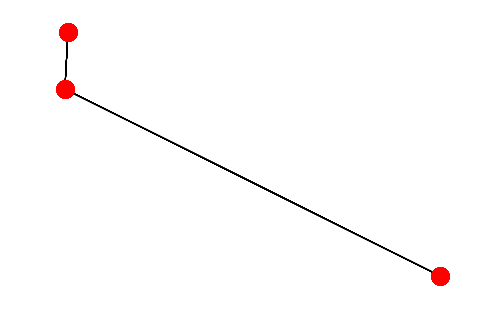

In [14]:
#collapsed code click on the arrow to show the full code --> code returns costprice array 
#run the model for the hinterland supply chain
for g in range(len(place_array)):
    for j in range(len(carrier_array)):
        for i in range(len(volume)):
            phi =  51.88121982094231 #latitude 
            lamb = 4.268813386454553 #longitude 

            phirad = phi * np.pi / 180
            lambrad = lamb*np.pi / 180

            theta = 10 #bearing 
            thetarad = theta * np.pi / 180

            d =  distance_hint #10_000 #km distance travelled  #xxx
            R =  6371 #km earths radius 
            delta = d/R #angular distance 
            
            import math

            lat2 = math.asin(math.sin(phirad)*math.cos(d/R) + math.cos(phirad)*math.sin(d/R)*math.cos(thetarad))
            phirad2 = lat2
            lon2 = lambrad + math.atan2(math.sin(thetarad)*math.sin(d/R)*math.cos(phirad), 
                                       math.cos(d/R)-math.sin(phirad)*math.sin(phirad2))
            londeg = lon2 * 180 / np.pi
            latdeg = lat2 * 180 / np.pi


            path = [(171.62457676362433, 37.506164466477216),     # 10_000km (171.62457676362433, 37.506164466477216)
                (4.268813386454553,51.88121982094231),# Botlek NL 
                (londeg, latdeg)] #500 km (5.674868835166208, 56.30182413509039)

            FG, positions, names = opentisim.core.convert_path_to_graph(path)
            nx.draw(FG, positions)
            FG.nodes

            origin = shapely.geometry.Point(171.62457676362433, 37.506164466477216)
            mid_destination = shapely.geometry.Point(4.268813386454553,51.88121982094231)
            end_destination = shapely.geometry.Point(londeg, latdeg)

            # prepare mapping
            mapping = {
                'node-0':'from_site',  # from node
                'node-1':'mid_site',  # mid node 
                'node-2': 'to_site'
                      }

            # apply mapping to graph object
            FG = nx.relabel_nodes(FG, mapping)
            FG.nodes

            #xxx
            startyear = startyear_chosen 
            lifecycle = lifecycle_chosen  
            years = list(range(startyear, startyear+lifecycle))
            carrier = carrier_array[j] #liquid hydrogen, MCH, DBT, ammonia
            place = place_array[g]
            transport_sc1 = 'vessel'
            t2 = hinterland_transport[g]
            #transport_sc2 = t2 #truck, train, barge
            #demand_hydrogen = volume[i]

            if place == 'decentralized':
                sc_export = {'berth_jetty','pipeline_jetty_-_terminal', 'storage', 'h2_conversion'}
                sc_import = {'berth_jetty','pipeline_jetty_-_terminal', 'storage'}
                sc_enduse = {'storage','h2_retrieval'}
                transport_sc2 = hinterland_transport_dec
            if place == 'centralized':
                sc_export = {'berth_jetty','pipeline_jetty_-_terminal', 'storage', 'h2_conversion'}
                sc_import = {'berth_jetty','pipeline_jetty_-_terminal', 'storage', 'h2_retrieval'}
                sc_enduse = {'storage'} 
                transport_sc2 = hinterland_transport_cen

            if carrier == 'liquid hydrogen':
                commodity_type_defaults = commodity_lhydrogen_data
                storage_type_defaults = storage_lh2_data
                h2conversion_type_defaults = h2conversion_lh2_data
                h2retrieval_type_defaults = h2retrieval_lh2_data
                vessel_defaults = largehydrogen_data
                barge_defaults = hydrogen_barge_data
                train_defaults = hydrogen_train_data
                truck_defaults = truck_lh2_data
                pipe_defaults = pipe_CGH2_data

            if carrier == 'ammonia':
                commodity_type_defaults = commodity_ammonia_data
                storage_type_defaults = storage_nh3_data
                h2conversion_type_defaults = h2conversion_nh3_data
                h2retrieval_type_defaults = h2retrieval_nh3_data
                vessel_defaults = largeammonia_data
                barge_defaults = ammonia_barge_data
                train_defaults = ammonia_train_data
                truck_defaults = truck_nh3_data
                pipe_defaults = pipe_CGH2_data

            if carrier == 'MCH':
                commodity_type_defaults = commodity_MCH_data
                storage_type_defaults = storage_MCH_data
                h2conversion_type_defaults = h2conversion_MCH_data
                h2retrieval_type_defaults = h2retrieval_MCH_data
                vessel_defaults = vlcc_data
                barge_defaults = MCH_barge_data
                train_defaults = MCH_train_data
                truck_defaults = truck_MCH_data
                pipe_defaults = pipe_CGH2_data

            if carrier == 'DBT':
                commodity_type_defaults = commodity_DBT_data
                storage_type_defaults = storage_DBT_data
                h2conversion_type_defaults = h2conversion_DBT_data
                h2retrieval_type_defaults = h2retrieval_DBT_data
                vessel_defaults = vlcc_data_DBT  
                barge_defaults = DBT_barge_data
                train_defaults = DBT_train_data
                truck_defaults = truck_DBT_data
                pipe_defaults = pipe_CGH2_data

            if transport_sc1 == 'vessel':
                transport_defaults_sc1 = vessel_defaults

            distancekm_sc1, durationdays_sc1, maxtrans_sc1, transloss_sc1, lossofload_sc1, numberoftrips_sc1 = character_shippingroute(origin, mid_destination, transport_defaults_sc1, carrier)
            
            if transport_sc2 == 'barge':
                transport_defaults_sc2 = barge_defaults 
                capacity_barge = barge_defaults["call_size"]
                loadingtime_barge = (barge_defaults["loadingtime"])*60*60
                unloadingtime_barge = (barge_defaults["unloadingtime"])*60*60
                velocity_barge = barge_defaults['avspeed']/3.6
                losses_barge = transloss_sc2
            if transport_sc2 == 'train':
                transport_defaults_sc2 = train_defaults 
            if transport_sc2 == 'truck':
                transport_defaults_sc2 = truck_defaults 
            if transport_sc2 == 'pipe':
                transport_defaults_sc2 = pipe_defaults

            distancekm_sc2, durationdays_sc2, maxtrans_sc2, transloss_sc2, lossofload_sc2, numberoftrips_sc2 = character_shippingroute(mid_destination, end_destination, transport_defaults_sc2, carrier)
            
            #define losses 
            jetty_loss = jetty_pipeline_data['losses']
            recplant_loss = h2retrieval_type_defaults['losses']
            conplant_loss = h2conversion_type_defaults['losses']
            storage_loss_end = storage_type_defaults['losses']*15
            storage_loss = storage_type_defaults['losses']*30
            transport_loss_sc1 = transloss_sc1 
            transport_loss_sc2 = transloss_sc2
            Hcontent = commodity_type_defaults['Hcontent']
            capacity_ship = barge_defaults["call_size"]


            #define demand and supply 
            nx.set_node_attributes(FG, [], 'througput')
            demand_hydrogen1 = volume1_end
            demand_hydrogen2 = volume2_end
            demand_hydrogen3 = volume3_end
            

            if place == 'decentralized':
                 #give the Demand that you need in tonnes of H2 
                demand_carrier1 = (demand_hydrogen1 * 100) / Hcontent #demand is converted to carrier 

                #end-use is dimensioned on this demand
                demand_enduse_out = demand_carrier1
                demand_enduse_in = (((storage_loss_end + recplant_loss)+100)*demand_carrier1)/100

                #import terminal is dimensioned on this demand plus losses (import terminal out)
                demand_import_out = (((transloss_sc2 + storage_loss_end + recplant_loss)+100)*demand_carrier1)/100
                demand_import_in = (((jetty_loss+storage_loss+transloss_sc2 + storage_loss_end + recplant_loss)+100)*demand_carrier1)/100

                #export terminal is dimensioned on this demand plus losses (export terminal out)
                demand_export_out = (((transloss_sc1+jetty_loss+storage_loss+transloss_sc2 + storage_loss_end + recplant_loss)+100)*demand_carrier1)/100
                demand_export_in = (((conplant_loss + storage_loss + jetty_loss + transloss_sc1+jetty_loss+storage_loss+transloss_sc2 + storage_loss_end + recplant_loss)+100)*demand_carrier1)/100

                #print(demand_enduse_out)
                #print(demand_export_in )
            if place == 'centralized':
                #give the Demand that you need in tonnes of H2 
                demand_carrier1 = (demand_hydrogen1 * 100) / Hcontent #demand is converted to carrier 

                #end-use is dimensioned on this demand
                demand_enduse_out = demand_carrier1
                demand_enduse_in = demand_carrier1

                #import terminal is dimensioned on this demand plus losses (import terminal out)
                demand_import_out = (((transloss_sc2)+100)*demand_carrier1)/100
                demand_import_in = (((jetty_loss+storage_loss+ recplant_loss +transloss_sc2 )+100)*demand_carrier1)/100

                #export terminal is dimensioned on this demand plus losses (export terminal out)
                demand_export_out = (((transloss_sc1+jetty_loss+storage_loss+transloss_sc2 + recplant_loss)+100)*demand_carrier1)/100
                demand_export_in = (((conplant_loss + storage_loss + jetty_loss + transloss_sc1+jetty_loss+storage_loss+transloss_sc2 + recplant_loss)+100)*demand_carrier1)/100

            #volume 2 
            if place == 'decentralized':
                 #give the Demand that you need in tonnes of H2 
                demand_carrier2 = (demand_hydrogen2 * 100) / Hcontent #demand is converted to carrier 

                #end-use is dimensioned on this demand
                demand_enduse_out2 = demand_carrier2
                demand_enduse_in2 = (((storage_loss_end + recplant_loss)+100)*demand_carrier2)/100

                #import terminal is dimensioned on this demand plus losses (import terminal out)
                demand_import_out2 = (((transloss_sc2 + storage_loss_end + recplant_loss)+100)*demand_carrier2)/100
                demand_import_in2 = (((jetty_loss+storage_loss+transloss_sc2 + storage_loss_end + recplant_loss)+100)*demand_carrier2)/100

                #export terminal is dimensioned on this demand plus losses (export terminal out)
                demand_export_out2 = (((transloss_sc1+jetty_loss+storage_loss+transloss_sc2 + storage_loss_end + recplant_loss)+100)*demand_carrier2)/100
                demand_export_in2 = (((conplant_loss + storage_loss + jetty_loss + transloss_sc1+jetty_loss+storage_loss+transloss_sc2 + storage_loss_end + recplant_loss)+100)*demand_carrier2)/100

                #print(demand_enduse_out)
                #print(demand_export_in )
            if place == 'centralized':
                #give the Demand that you need in tonnes of H2 
                demand_carrier2 = (demand_hydrogen2 * 100) / Hcontent #demand is converted to carrier 

                #end-use is dimensioned on this demand
                demand_enduse_out2 = demand_carrier2
                demand_enduse_in2 = demand_carrier2

                #import terminal is dimensioned on this demand plus losses (import terminal out)
                demand_import_out2 = (((transloss_sc2)+100)*demand_carrier2)/100
                demand_import_in2 = (((jetty_loss+storage_loss+ recplant_loss +transloss_sc2 )+100)*demand_carrier2)/100

                #export terminal is dimensioned on this demand plus losses (export terminal out)
                demand_export_out2 = (((transloss_sc1+jetty_loss+storage_loss+transloss_sc2 + recplant_loss)+100)*demand_carrier2)/100
                demand_export_in2 = (((conplant_loss + storage_loss + jetty_loss + transloss_sc1+jetty_loss+storage_loss+transloss_sc2 + recplant_loss)+100)*demand_carrier2)/100

            #volume 3 
            if place == 'decentralized':
                 #give the Demand that you need in tonnes of H2 
                demand_carrier3 = (demand_hydrogen3 * 100) / Hcontent #demand is converted to carrier 

                #end-use is dimensioned on this demand
                demand_enduse_out3 = demand_carrier3
                demand_enduse_in3 = (((storage_loss_end + recplant_loss)+100)*demand_carrier3)/100

                #import terminal is dimensioned on this demand plus losses (import terminal out)
                demand_import_out3 = (((transloss_sc2 + storage_loss_end + recplant_loss)+100)*demand_carrier3)/100
                demand_import_in3 = (((jetty_loss+storage_loss+transloss_sc2 + storage_loss_end + recplant_loss)+100)*demand_carrier3)/100

                #export terminal is dimensioned on this demand plus losses (export terminal out)
                demand_export_out3 = (((transloss_sc1+jetty_loss+storage_loss+transloss_sc2 + storage_loss_end + recplant_loss)+100)*demand_carrier3)/100
                demand_export_in3 = (((conplant_loss + storage_loss + jetty_loss + transloss_sc1+jetty_loss+storage_loss+transloss_sc2 + storage_loss_end + recplant_loss)+100)*demand_carrier3)/100

                #print(demand_enduse_out)
                #print(demand_export_in )
            if place == 'centralized':
                #give the Demand that you need in tonnes of H2 
                demand_carrier3 = (demand_hydrogen3 * 100) / Hcontent #demand is converted to carrier 

                #end-use is dimensioned on this demand
                demand_enduse_out3 = demand_carrier3
                demand_enduse_in3 = demand_carrier3

                #import terminal is dimensioned on this demand plus losses (import terminal out)
                demand_import_out3 = (((transloss_sc2)+100)*demand_carrier3)/100
                demand_import_in3 = (((jetty_loss+storage_loss+ recplant_loss +transloss_sc2 )+100)*demand_carrier3)/100

                #export terminal is dimensioned on this demand plus losses (export terminal out)
                demand_export_out3 = (((transloss_sc1+jetty_loss+storage_loss+transloss_sc2 + recplant_loss)+100)*demand_carrier3)/100
                demand_export_in3 = (((conplant_loss + storage_loss + jetty_loss + transloss_sc1+jetty_loss+storage_loss+transloss_sc2 + recplant_loss)+100)*demand_carrier3)/100


            supply = []
            for year in years:
                if year >= 2020 and year < 2030:
                    supply.append(demand_export_out)
                elif year >= 2030 and year <2040:
                    supply.append(demand_export_out2)
                else:
                    supply.append(demand_export_out3)

            throughput_from = pd.DataFrame({'year': years, 
                                 'volume': supply})
            FG.nodes['from_site']['througput'] = throughput_from

            demand_mid = []

            for year in years:
                if year >= 2020 and year < 2030:
                    demand_mid.append(demand_import_out)
                elif year >= 2030 and year <2040:
                    demand_mid.append(demand_import_out2)
                else:
                    demand_mid.append(demand_import_out3)

            throughput_mid = pd.DataFrame({'year': years, 
                                 'volume': demand_mid})

            FG.nodes['mid_site']['througput'] = throughput_mid

            demand_end = []
            for year in years:
                if year >= 2020 and year < 2030:
                    demand_end.append(demand_enduse_out)
                elif year >= 2030 and year <2040:
                    demand_end.append(demand_enduse_out2)
                else:
                    demand_end.append(demand_enduse_out3)

            throughput_to = pd.DataFrame({'year': years, 
                                 'volume': demand_end})


            FG.nodes['to_site']['througput'] = throughput_to

            # add an empty terminal property
            nx.set_node_attributes(FG, [], 'terminal')

            # add an empty OpenCLSim Site property
            nx.set_node_attributes(FG, [], 'site')

            if carrier == 'liquid hydrogen':
                commodity_lhydrogen_data['smallhydrogen_perc'] = 0
                commodity_lhydrogen_data['largehydrogen_perc'] = 100
                commodity_lhydrogen_data['historic_data'] = []
                commodity_lhydrogen_data['scenario_data'] = []
                lhydrogen = Commodity(**commodity_lhydrogen_data)
                lhydrogen.scenario_data = throughput_from
                demand = [lhydrogen] 

            if carrier == 'ammonia':
                commodity_ammonia_data["smallammonia_perc"] = 0
                commodity_ammonia_data["largeammonia_perc"] = 100
                commodity_ammonia_data['historic_data'] = []
                commodity_ammonia_data['scenario_data'] = []
                ammonia = Commodity(**commodity_ammonia_data)
                ammonia.scenario_data = throughput_from  #choose what carrier
                demand = [ammonia] 

            if carrier == 'MCH':
                commodity_MCH_data["handysize_perc"] = 0
                commodity_MCH_data["panamax_perc"] = 0
                commodity_MCH_data["vlcc_perc"] = 100
                commodity_MCH_data['historic_data'] = []
                commodity_MCH_data['scenario_data'] = []
                MCH = Commodity(**commodity_MCH_data)
                MCH.scenario_data = throughput_from  #choose what carrier
                demand = [MCH] 
            if carrier == 'DBT':
                commodity_DBT_data["handysize_perc"] = 0
                commodity_DBT_data["panamax_perc"] = 0
                commodity_DBT_data["vlcc_perc"] = 100
                commodity_DBT_data['historic_data'] = []
                commodity_DBT_data['scenario_data'] = []
                DBT = Commodity(**commodity_DBT_data)
                DBT.scenario_data = throughput_from  #choose what carrier
                demand = [DBT] 

            # instantiate vessels
            Smallhydrogen = Vessel(**smallhydrogen_data)
            Largehydrogen = Vessel(**largehydrogen_data)
            Smallammonia = Vessel(**smallammonia_data)
            Largeammonia = Vessel(**largeammonia_data)
            Handysize = Vessel(**handysize_data)
            Panamax = Vessel(**panamax_data)

            if carrier == 'MCH':
                VLCC = Vessel(**vlcc_data)
            elif carrier == 'DBT':
                VLCC = Vessel(**vlcc_data_DBT)
            else:
                VLCC = Vessel(**vlcc_data)

            # vessels variable: contains info on vessels (to be added to Terminal.elements)
            vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC] 

            if carrier == 'MCH' or carrier == 'DBT':
                dwelltime = 30/365 #30/365
            if carrier == 'liquid hydrogen':
                dwelltime = 15/365 #15/365
            else:
                dwelltime = 30/365 #30/365

            # Instantiate OpenTISim Terminal
            from_site_terminal = opentisim.liquidbulk.ExportTerminal(
                        startyear = None, 
                        lifecycle = 1, 
                        distance = distancekm_sc1, 
                        elements = demand + vessels, 
                        operational_hours = 16*365,   # example Wijnand
                        terminal_supply_chain=sc_export,
                        debug=False,
                        commodity_type_defaults=commodity_type_defaults,
                        storage_type_defaults=storage_type_defaults,
                        kendall='E2/E2/n',
                        allowable_waiting_service_time_ratio_berth=0.15,
                        h2conversion_type_defaults=h2conversion_type_defaults,
                        allowable_dwelltime= dwelltime)

            from_site_terminal.modelframe = list(range(startyear, startyear + lifecycle))
            from_site_terminal.revenues = []
            from_site_terminal.demurrage = []

            # add an OpenTISim Terminal to the graph
            FG.nodes['from_site']['terminal'] = from_site_terminal

            if carrier == 'liquid hydrogen':
                commodity_lhydrogen_data['smallhydrogen_perc'] = 0
                commodity_lhydrogen_data['largehydrogen_perc'] = 100
                commodity_lhydrogen_data['historic_data'] = []
                commodity_lhydrogen_data['scenario_data'] = []
                lhydrogen = Commodity(**commodity_lhydrogen_data)
                lhydrogen.scenario_data = throughput_mid
                demand = [lhydrogen] 

            if carrier == 'ammonia':
                commodity_ammonia_data["smallammonia_perc"] = 0
                commodity_ammonia_data["largeammonia_perc"] = 100
                commodity_ammonia_data['historic_data'] = []
                commodity_ammonia_data['scenario_data'] = []
                ammonia = Commodity(**commodity_ammonia_data)
                ammonia.scenario_data = throughput_mid  #choose what carrier
                demand = [ammonia] 

            if carrier == 'MCH':
                commodity_MCH_data["handysize_perc"] = 0
                commodity_MCH_data["panamax_perc"] = 0
                commodity_MCH_data["vlcc_perc"] = 100
                commodity_MCH_data['historic_data'] = []
                commodity_MCH_data['scenario_data'] = []
                MCH = Commodity(**commodity_MCH_data)
                MCH.scenario_data = throughput_mid  #choose what carrier
                demand = [MCH] 

            if carrier == 'DBT':
                commodity_DBT_data["handysize_perc"] = 0
                commodity_DBT_data["panamax_perc"] = 0
                commodity_DBT_data["vlcc_perc"] = 100
                commodity_DBT_data['historic_data'] = []
                commodity_DBT_data['scenario_data'] = []
                DBT = Commodity(**commodity_DBT_data)
                DBT.scenario_data = throughput_mid  #choose what carrier
                demand = [DBT] 

            # instantiate vessels
            Smallhydrogen = Vessel(**smallhydrogen_data)
            Largehydrogen = Vessel(**largehydrogen_data)
            Smallammonia = Vessel(**smallammonia_data)
            Largeammonia = Vessel(**largeammonia_data)
            Handysize = Vessel(**handysize_data)
            Panamax = Vessel(**panamax_data)

            if carrier == 'MCH':
                VLCC = Vessel(**vlcc_data)
            elif carrier == 'DBT':
                VLCC = Vessel(**vlcc_data_DBT)
            else:
                VLCC = Vessel(**vlcc_data)

            # vessels variable: contains info on vessels (to be added to Terminal.elements)
            vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC]

            if carrier == 'MCH' or carrier == 'DBT':
                dwelltime = 30/365
            if carrier == 'liquid hydrogen':
                dwelltime = 15/365
            else:
                dwelltime = 30/365

            # Instantiate OpenTISim Terminal
            mid_site_terminal =  opentisim.liquidbulk.System(
                        startyear = None, 
                        lifecycle = 1, 
                        elements = demand + vessels, 
                        operational_hours = 16*365,   # example Wijnand
                        terminal_supply_chain=sc_import,
                        debug=False,
                        commodity_type_defaults=commodity_type_defaults,
                        storage_type_defaults=storage_type_defaults,
                        kendall='E2/E2/n',
                        allowable_waiting_service_time_ratio_berth=0.15,
                        h2retrieval_type_defaults=h2retrieval_type_defaults,
                        allowable_dwelltime= dwelltime)

            mid_site_terminal.modelframe = list(range(startyear, startyear + lifecycle))
            mid_site_terminal.revenues = []
            mid_site_terminal.demurrage = []
            mid_site_terminal.transport_sc2 = transport_sc2
            mid_site_terminal.place = place

            # add an OpenTISim Terminal to the graph
            FG.nodes['mid_site']['terminal'] = mid_site_terminal

            if carrier == 'liquid hydrogen':
                commodity_lhydrogen_data['smallhydrogen_perc'] = 0
                commodity_lhydrogen_data['largehydrogen_perc'] = 100
                commodity_lhydrogen_data['historic_data'] = []
                commodity_lhydrogen_data['scenario_data'] = []
                lhydrogen = Commodity(**commodity_lhydrogen_data)
                lhydrogen.scenario_data = throughput_to
                demand = [lhydrogen] 

            if carrier == 'ammonia':
                commodity_ammonia_data["smallammonia_perc"] = 0
                commodity_ammonia_data["largeammonia_perc"] = 100
                commodity_ammonia_data['historic_data'] = []
                commodity_ammonia_data['scenario_data'] = []
                ammonia = Commodity(**commodity_ammonia_data)
                ammonia.scenario_data = throughput_to  #choose what carrier
                demand = [ammonia] 

            if carrier == 'MCH':
                commodity_MCH_data["handysize_perc"] = 0
                commodity_MCH_data["panamax_perc"] = 0
                commodity_MCH_data["vlcc_perc"] = 100
                commodity_MCH_data['historic_data'] = []
                commodity_MCH_data['scenario_data'] = []
                MCH = Commodity(**commodity_MCH_data)
                MCH.scenario_data = throughput_to  #choose what carrier
                demand = [MCH] 

            if carrier == 'DBT':
                commodity_DBT_data["handysize_perc"] = 0
                commodity_DBT_data["panamax_perc"] = 0
                commodity_DBT_data["vlcc_perc"] = 100
                commodity_DBT_data['historic_data'] = []
                commodity_DBT_data['scenario_data'] = []
                DBT = Commodity(**commodity_DBT_data)
                DBT.scenario_data = throughput_to  #choose what carrier
                demand = [DBT] 

            if carrier == 'MCH' or carrier == 'DBT':
                dwelltime = 15/365
            if carrier == 'liquid hydrogen':
                dwelltime = 7/365
            else:
                dwelltime = 15/365

            # Instantiate OpenTISim Terminal
            to_site_terminal =  opentisim.liquidbulk.EndUseLocation(
                        startyear = None, 
                        lifecycle = 1, 
                        elements = demand, 
                        operational_hours = 16*365,   # example Wijnand
                        terminal_supply_chain= sc_enduse,
                        debug=False,
                        commodity_type_defaults=commodity_type_defaults,
                        storage_type_defaults=storage_type_defaults,
                        h2retrieval_type_defaults=h2retrieval_type_defaults,
                        allowable_dwelltime= dwelltime)


            to_site_terminal.modelframe = list(range(startyear, startyear + lifecycle))
            to_site_terminal.revenues = []
            to_site_terminal.demurrage = []
            to_site_terminal.place = place


            # add an OpenTISim Terminal to the graph
            FG.nodes['to_site']['terminal'] = to_site_terminal

            supplychain_1 = SupplyChain(
                name='Supplychain 1',
                elements = [],
                origin = 'from_site',
                origin_latent_demand = 0,
                origin_online_throughput = 0,
                destination='mid_site',
                destination_latent_demand = 0,
                destination_online_throughput = 0,
                condition=[{"type": "container", "concept": 'from_site', "state": "empty"}],
                capacity=None)

            if t2 == 'pipe':
                condition_sc2 = 'pipe'
            else: 
                condition_sc2 = [{"type": "container", "concept": 'mid_site', "state": "empty"}]

            supplychain_2 = SupplyChain(
                name='Supplychain 2',
                elements = [],
                origin = 'mid_site',
                origin_latent_demand = 0,
                origin_online_throughput = 0,
                destination='to_site',
                destination_latent_demand = 0,
                destination_online_throughput = 0,
                condition=condition_sc2,
                capacity=None)

            supplychains = [supplychain_1, supplychain_2]

            #ship and inland transport characteristics 
            capacity_ship = vessel_defaults["call_size"]
            pump_ship = vessel_defaults["pump_capacity"]
            loadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
            unloadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
            velocity_ship = vessel_defaults['avspeed']/3.6 # #25 km/h --> m/s 
            losses_ship = transloss_sc1

            if transport_sc2 == 'barge':
                capacity_barge = barge_defaults["call_size"]
                loadingtime_barge = (barge_defaults["loadingtime"])*60*60
                unloadingtime_barge = (barge_defaults["unloadingtime"])*60*60
                velocity_barge = barge_defaults['avspeed']/3.6
                losses_barge = transloss_sc2
            if transport_sc2 == 'train':
                capacity_barge = train_defaults["call_size"]
                loadingtime_barge = (train_defaults["loadingtime"])*60*60
                unloadingtime_barge = (train_defaults["unloadingtime"])*60*60
                velocity_barge = train_defaults['avspeed']/3.6
                losses_barge = transloss_sc2
            if transport_sc2 == 'truck':
                capacity_barge = truck_defaults["capacity"]
                loadingtime_barge = (truck_defaults["loadingtime"])*60*60
                unloadingtime_barge = (truck_defaults["unloadingtime"])*60*60
                velocity_barge = truck_defaults['avspeed']/3.6
                losses_barge = transloss_sc2

            if carrier == 'MCH' or carrier == 'DBT':
                loadingtime_ship = 2*loadingtime_ship
                unloadingtime_ship = 2*unloadingtime_ship
                loadingtime_barge = 2*(barge_defaults["loadingtime"])*60*60
                unloadingtime_barge = 2*(barge_defaults["unloadingtime"])*60*60

            #define what to print
            Debug = False
            debug = False

            #create empty dataframes
            commodity_lhydrogen_data['scenario_data'] = []
            commodity_ammonia_data['scenario_data'] = []
            commodity_MCH_data['scenario_data'] = []
            dataframe_openclsim = []
            dataframe_openclsim2 = []

            years = list(range(startyear, startyear+lifecycle))
            years1 =  list(range(startyear, startyear+lifecycle))
            years2 = list(range(startyear+2,startyear+lifecycle))

            for index_year,year in enumerate(years):
                for supplychain in supplychains:
                    count_vessel = 0 
                    count_transport = 0 
                    FG.nodes[supplychain.origin]['site'] = []
                    FG.nodes[supplychain.destination]['site'] = []
                # OpenTISim: op 1 januari neem je al je beslissingen (terminals + supply chains)
                if debug == True:
                    print('')
                    print('simulation for year: {} ---------------'.format(year))

                for supplychain in supplychains:
                    # 1. als de origin node in de supplychain een throughput property heeft, 
                    # bereken dan de benodigde terminal dimensies
                    throughput_online_origin = 0
                    if type(FG.nodes[supplychain.origin]['througput']) == pd.core.frame.DataFrame:
                        FG.nodes[supplychain.origin]['terminal'].startyear = year
                        FG.nodes[supplychain.origin]['terminal'].debug = Debug
                        #FG.nodes[supplychain.origin]['terminal'].years = years1
                        #print(FG.nodes[supplychain.origin]['terminal'].__dict__)
                        FG.nodes[supplychain.origin]['terminal'].simulate()

                        throughput_online_origin, throughput_terminal_in,throughput_online_jetty_in, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  FG.nodes[supplychain.origin]['terminal'].throughput_elements(year)

                        if debug == True:
                            print('Terminal: {}, year: {}, throughput online: {}'.format(supplychain.origin, year, throughput_online_origin))
                            print('')
                            print()

                        #supplychain.origin_online_throughput = throughput_online_jetty_origin
                        supplychain.origin_online_throughput = throughput_online_origin

                     # 2. als de destination node in de supplychain een throughput property heeft, 
                    # bereken dan de benodigde terminal dimensies
                    throughput_online_destination = 0
                    if type(FG.nodes[supplychain.destination]['througput']) == pd.core.frame.DataFrame:

                        FG.nodes[supplychain.destination]['terminal'].startyear = year
                        FG.nodes[supplychain.destination]['terminal'].debug = Debug
                        #FG.nodes[supplychain.destination]['terminal'].years = years1
                        FG.nodes[supplychain.destination]['terminal'].simulate()

                        throughput_online_destination, throughput_terminal_in,throughput_online_jetty_in_dest, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  = FG.nodes[supplychain.destination]['terminal'].throughput_elements(year)

                        if debug == True:
                            print('Terminal: {}, year: {}, throughput: {}'.format(supplychain.destination, year, throughput_online_destination))
                            print('')

                        supplychain.destination_online_throughput = throughput_online_jetty_in_dest

                    # 3. als de origin een throughput heeft, maar de destination niet,
                    # voeg dan de throughput van de origin toe aan die van de destination 
                    if throughput_online_origin != 0 and throughput_online_destination == 0:
                        if debug == True:
                            print('The origin is generating throughput. I need a latent demand in the destination location.')

            #             The origin is generating throughput. I need a latent demand in the destination location.
            #             Terminal: mid_site, year: 2004, throughput: 1617850.649350649

                        #supplychain.destination_latent_demand = throughput_online_jetty_origin
                        supplychain.destination_latent_demand = throughput_online_origin

                        # Use the throughput at the other end of the supply chain as a latent demand

                        # Liquid hydrogen
                        if carrier == 'liquid hydrogen':
                            commodity_lhydrogen_data['historic_data'] = []
                            lhydrogen = Commodity(**commodity_lhydrogen_data)
                            lhydrogen.scenario_data.append({'year': year, 'volume': throughput_online_jetty_origin})
                            lhydrogen.scenario_data = pd.DataFrame(lhydrogen.scenario_data)
                            demand = [lhydrogen]
                            #print(lhydrogen.scenario_data)


                        # Ammonia
                        if carrier == 'ammonia':
                            commodity_ammonia_data['historic_data'] = []
                            ammonia = Commodity(**commodity_ammonia_data)
                            ammonia.scenario_data.append({'year': year, 'volume': throughput_online_jetty_origin})
                            ammonia.scenario_data = pd.DataFrame(ammonia.scenario_data)
                            demand = [ammonia]

                        # MCH
                        if carrier == 'MCH': 
                            commodity_MCH_data['historic_data'] = []
                            MCH = Commodity(**commodity_MCH_data)
                            MCH.scenario_data.append({'year': year, 'volume': throughput_online_jetty_origin})
                            MCH.scenario_data = pd.DataFrame(MCH.scenario_data)
                            demand = [MCH]

                        if carrier == 'DBT': 
                            commodity_DBT_data['historic_data'] = []
                            DBT = Commodity(**commodity_DBT_data)
                            DBT.scenario_data.append({'year': year, 'volume': throughput_online_jetty_origin})
                            DBT.scenario_data = pd.DataFrame(DBT.scenario_data)
                            demand = [DBT]


                        # adopt vessels from the other node
                        vessels = [x for x in FG.nodes[supplychain.origin]['terminal'].elements if type(x) == Vessel]

                        # find all terminal_elements that are NOT a commodity
                        terminal_elements = [x for x in FG.nodes[supplychain.destination]['terminal'].elements if type(x) != Commodity and type(x) != Vessel]

                        # add terminal_elements + new demands
                        FG.nodes[supplychain.destination]['terminal'].elements = terminal_elements + demand + vessels

                        FG.nodes[supplychain.destination]['terminal'].startyear = year
                        FG.nodes[supplychain.destination]['terminal'].debug = Debug
                        FG.nodes[supplychain.destination]['terminal'].years = years2
                        FG.nodes[supplychain.destination]['terminal'].simulate()

                        throughput_online_destination, throughput_terminal_in,throughput_online_jetty_in_dest, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  FG.nodes[supplychain.destination]['terminal'].throughput_elements(year)

                        if debug == True:
                            print('Terminal: {}, year: {}, throughput: {}'.format(supplychain.destination, year, throughput_online_jetty_destination))
                            print('')

                        #supplychain.destination_online_throughput = throughput_online_jetty_destination
                        supplychain.destination_online_throughput = throughput_online_jetty_in_dest


                    # 4. als de origin geen throughput heeft, maar de destination wel,
                    # voeg dan de throughput van de destination toe aan die van de origin 
                    if throughput_online_origin == 0 and throughput_online_destination != 0:
                        if debug == True:
                            print('The destination is generating throughput. I need latent demand in the origin location')

                        supplychain.origin_latent_demand = throughput_online_jetty_in_dest #throughput_online_jetty_destination

                        # Use the throughput at the other end of the supply chain as a latent demand
                        supply = list(np.matlib.repmat(throughput_online_jetty_destination,1,1)[0])
                        througput_origin = pd.DataFrame({'year': year, 'volume': supply})

                        # Liquid hydrogen
                        if carrier == 'liquid hydrogen':
                            commodity_lhydrogen_data['historic_data'] = []
                            #lhydrogen = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_lhydrogen_data)

                            if lhydrogen.scenario_data['volume'].values[-1] > throughput_online_jetty_destination:
                                lhydrogen.scenario_data = lhydrogen.scenario_data
                                #print('true')
                            else:
                                lhydrogen.scenario_data.append({'year': year, 'volume': throughput_online_jetty_destination}) #xxx
                                lhydrogen.scenario_data = pd.DataFrame(lhydrogen.scenario_data)
                                #print('false')
                            demand = [lhydrogen]

                        if carrier == 'ammonia':
                            commodity_ammonia_data['historic_data'] = []
                            if ammonia.scenario_data['volume'].values[-1] > throughput_online_jetty_destination:
                                ammonia.scenario_data = ammonia.scenario_data
                                #print('true')
                            else:
                                ammonia.scenario_data.append({'year': year, 'volume': throughput_online_jetty_destination}) #xxx
                                ammonia.scenario_data = pd.DataFrame(ammonia.scenario_data)
                                #print('false')
                            demand = [ammonia]

                        if carrier == 'MCH':
                            commodity_MCH_data['historic_data'] = []
                            if MCH.scenario_data['volume'].values[-1] > throughput_online_jetty_destination:
                                MCH.scenario_data = MCH.scenario_data
                                #print('true')
                            else:
                                MCH.scenario_data.append({'year': year, 'volume': throughput_online_jetty_destination}) #xxx
                                MCH.scenario_data = pd.DataFrame(MCH.scenario_data)
                                #print('false')
                            demand = [MCH]

                        if carrier == 'DBT':
                            commodity_DBT_data['historic_data'] = []
                            if DBT.scenario_data['volume'].values[-1] > throughput_online_jetty_destination:
                                DBT.scenario_data = DBT.scenario_data
                                #print('true')
                            else:
                                DBT.scenario_data.append({'year': year, 'volume': throughput_online_jetty_destination}) #xxx
                                DBT.scenario_data = pd.DataFrame(DBT.scenario_data)
                                #print('false')
                            demand = [DBT]


                        # adopt vessels from the other node
                        vessels = [x for x in FG.nodes[supplychain.destination]['terminal'].elements if type(x) == Vessel]

                        # find all terminal_elements that are NOT a commodity
                        terminal_elements = [x for x in FG.nodes[supplychain.origin]['terminal'].elements if type(x) != Commodity and type(x) != Vessel]

                        # add terminal_elements + new demands
                        FG.nodes[supplychain.origin]['terminal'].elements = terminal_elements + demand + vessels

                        FG.nodes[supplychain.origin]['terminal'].startyear = year
                        FG.nodes[supplychain.origin]['terminal'].debug = Debug
                        FG.nodes[supplychain.origin]['terminal'].years = years2
                        FG.nodes[supplychain.origin]['terminal'].simulate()

                        throughput_online_origin, throughput_terminal_in,throughput_online_jetty_in, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  = FG.nodes[supplychain.origin]['terminal'].throughput_elements(year)

                        if debug == True:
                            print('Terminal: {}, year: {}, throughput: {}'.format(supplychain.origin, year, throughput_online_jetty_origin))
                            print('')

                        supplychain.origin_online_throughput = throughput_online_origin

                # 5. run openclsim calculation
                # OpenCLSim: tussen 2 januari - 31 december ga je transporteren
                if supplychain.origin_online_throughput !=0 and supplychain.destination_online_throughput!=0:

                    # step past all supplychains to initiate the sites and vessels
                    for index, supplychain in enumerate(supplychains):
                        if index == 0:
                            if supplychain.condition == 'pipe':
                                if debug == True:
                                    print('pipe transport')
                            else:
                                #level_from_site = min([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                                level_from_site = supplychain.origin_online_throughput
                                level_mid_site = 0
                                #activities = []
                                while level_from_site != 0:
                                    count_vessel += 1
                                    if debug == True:
                                        print('**Add a ship**')
                                    #make environment 
                                    #simulation_start  = datetime.datetime(year, 1, 1, 0, 0)
                                    #my_env = simpy.Environment(initial_time=simulation_start.timestamp())
                                    simulation_start = 0 
                                    my_env = simpy.Environment(initial_time=simulation_start)


                                    # origin
                                    capacity_from_site = max([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                                    #level_from_site = min([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                                    data_from_site = {"env": my_env,
                                                 "name": supplychain.origin,
                                                 "geometry": FG.nodes[supplychain.origin]['geometry'],
                                                 "capacity": capacity_from_site, 
                                                 "level": level_from_site
                                                 }
                                    FG.nodes[supplychain.origin]['site'] = Site(**data_from_site)
                                    from_site = Site(**data_from_site)

                                    # destination
                                    capacity_mid_site = capacity_from_site #max([supplychain.destination_online_throughput, supplychain.origin_latent_demand])
                                    #level_to_site = min([supplychain.destination_online_throughput, supplychain.origin_latent_demand])
                                    data_mid_site = {"env": my_env,
                                                 "name": supplychain.destination,
                                                 "geometry": FG.nodes[supplychain.destination]['geometry'],
                                                 "capacity": capacity_mid_site, 
                                                 "level": level_mid_site #0
                                                 }
                                    FG.nodes[supplychain.destination]['site'] = Site(**data_mid_site)
                                    mid_site = Site(**data_mid_site)
                                    capacity_bog = capacity_mid_site

                                    boil_off_container = {"env": my_env,
                                                 "name": 'boil-off',
                                                  "geometry": FG.nodes[supplychain.destination]['geometry'],
                                                  #"loading_rate": 0.00001,
                                                 #"unloading_rate": 0.00001,
                                                 "capacity": capacity_bog, 
                                                  "compute_v": lambda x: 0
                                                }


                                    boil_off01 = BoiloffResource(**boil_off_container)

                                    if debug == True:
                                        print('capacity at origin', capacity_from_site)
                                        print('level at origin', level_from_site)
                                        print('capacity at destination', capacity_mid_site)
                                        print('level at destination', level_mid_site)

                                    # vessels
                                    # prepare input data for vessel_01
                                    data_vessel01 = {"env": my_env,
                                                     "name": "vessel " + supplychain.name,
                                                     "geometry": FG.nodes[supplychain.origin]['geometry'], 
                                                     "loading_rate": 0.00001,
                                                     "unloading_rate": 0.00001,
                                                     "capacity": capacity_ship,
                                                     "compute_v": lambda x: velocity_ship
                                                    }


                                    # instantiate vessel_01 
                                    vessel01 = TransportProcessingResource(**data_vessel01)

                                    supplychain.elements = [vessel01]

                                    # use the sites from the graph and the vessels from the supplychains to construct activities
                                    #activities = []

                                    # initialise registry
                                    registry = {}
                                    if debug == True:
                                        print('transporter activity between from_site and mid_site')

                                    # create a list of the sub processes
                                    requested_resources1 = {}

                                    sub_processes = [
                                        openclsim.model.MoveActivity(
                                            env=my_env,
                                            name="sailing empty",
                                            registry=registry,
                                            mover=vessel01,
                                            destination=from_site,
                                            requested_resources=requested_resources1,
                                        ),
                                        openclsim.model.ShiftAmountActivity(
                                            env=my_env,
                                            name="loading",
                                            registry=registry,
                                            processor=vessel01,
                                            origin=from_site,
                                            destination=vessel01,
                                            amount=capacity_ship,
                                            duration=loadingtime_ship,
                                            requested_resources=requested_resources1,
                                        ),
                                        openclsim.model.MoveActivity(
                                            env=my_env,
                                            name="sailing full",
                                            registry=registry,
                                            mover=vessel01,
                                            destination=mid_site,
                                            requested_resources=requested_resources1,
                                        ),
                                        openclsim.model.ShiftAmountActivity(
                                            env=my_env,
                                            name="boil off",
                                            registry=registry,
                                            processor=vessel01,
                                            origin=vessel01,
                                            destination=boil_off01,
                                            amount=lossofload_sc1,
                                            duration=0,
                                            requested_resources=requested_resources1,
                                        ),
                                        openclsim.model.ShiftAmountActivity(
                                            env=my_env,
                                            name="unloading",
                                            registry=registry,
                                            processor=vessel01,
                                            origin=vessel01,
                                            destination=mid_site,
                                            amount=capacity_ship,
                                            duration=unloadingtime_ship, #in seconds 
                                            requested_resources=requested_resources1,
                                        ),
                                        openclsim.model.BasicActivity(
                                            env=my_env,
                                            name="basic activity",
                                            registry=registry,
                                            duration=0,
                                            additional_logs=[vessel01],
                                            requested_resources=requested_resources1,
                                        ),
                                    ]

                                    # create a 'sequential activity' that is made up of the 'sub_processes'
                                    sequential_activity = openclsim.model.SequentialActivity(
                                        env=my_env,
                                        name="sequential_activity_subcycle_1",
                                        registry=registry,
                                        sub_processes=sub_processes,
                                    )

                                    #print(sub_processes[3])

                                    # now the site has been created we can add the site variable to the condition
                                    if level_from_site > maxtrans_sc1:#1019700:
                                        condition = [{"type": "activity", "name": "while_sequential_activity_subcycle ", "state": "done"}]

                                        while_activity = openclsim.model.WhileActivity(
                                            env=my_env,
                                            name="while_sequential_activity_subcycle ", #+ supplychain.name,
                                            registry=registry,
                                            sub_processes=[sequential_activity],
                                            condition_event=condition,
                                        )

                                        model.register_processes([while_activity])
                                        secyear = 60*60*24*365
                                        my_env.run(until = secyear)
                                    else:
                                        condition1 = [{"type": "container", "concept": from_site, "state": "empty"}]

                                        #change
                                        sub_processes_new = sub_processes.pop(3)

                                        sequential_activity = openclsim.model.SequentialActivity(
                                            env=my_env,
                                            name="sequential_activity_subcycle_1",
                                            registry=registry,
                                            sub_processes=sub_processes,
                                        )


                                        while_activity = openclsim.model.WhileActivity(
                                            env=my_env,
                                            name="while_sequential_activity_subcycle ", #+ supplychain.name,
                                            registry=registry,
                                            sub_processes=[sequential_activity],
                                            condition_event=condition1,
                                        )

                                        model.register_processes([while_activity])
                                        my_env.run()

                                        #condition = [{"type": vessel01, "concept": from_site, "state": "empty"}]

                                    df1 = plot.get_log_dataframe(from_site, [while_activity, *sub_processes])
                                    level_from_site = df1['container level'].values[-1]

                                    df2 = plot.get_log_dataframe(mid_site, [while_activity, *sub_processes])
                                    level_mid_site = df2['container level'].values[-1]

                                    df4 = plot.get_log_dataframe(vessel01, [while_activity, *sub_processes])

                                    if level_from_site > maxtrans_sc1:
                                        df3 = plot.get_log_dataframe(boil_off01, [while_activity, *sub_processes])

                                        if df4['container level'].values[-1] != 0:
                                            level_boil_off = df3['container level'].values[-1] + lossofload_sc1
                                        else: 
                                            level_boil_off = df3['container level'].values[-1] 


                                        level_vessel = df4['container level'].values[-1]
                                            #level_vessel = 0 #vessel is emptied 

                                    if df4['container level'].values[-1] != 0:
                                        new = df2['container level'].values[-1] + (df4['container level'].values[-1]-lossofload_sc1)
                                    else: 
                                        new = df2['container level'].values[-1] + df4['container level'].values[-1]

                                    level_mid_site = new

                                    if debug == True:
                                                print(
                                                    '     a total of {} ton of hydrogen is at the origin'.format(
                                                        level_from_site))

                #                                 print(
                #                                     '     a total of {} ton of hydrogen is at boil-off'.format(
                #                                         level_boil_off ))
                #                                 print(
                #                                     '     a total of {} ton of hydrogen is at vessel'.format(
                #                                         level_vessel ))
                                                print(
                                                    '     a total of {} ton of hydrogen is at the destination when last vessel is emptied'.format(
                                                        level_mid_site))


                                dataframe_openclsim.append({'year': year,'level to site': level_mid_site, 'vessel count':count_vessel,})
                                #print(count_vessel)
                        if index == 1:
                            if supplychain.condition == 'pipe':
                                if debug == True:
                                    print('pipe transport')
                            else:
                                #level_from_site = min([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                                level_mid_site_sc2 = supplychain.origin_online_throughput
                                level_to_site_sc2 = 0
                                #activities = []
                                while level_mid_site_sc2 != 0:
                                    count_transport += 1
                                    if debug == True:
                                        print('**Add a transport mode to hinterland**')
                                    #make environment 
                                    #simulation_start  = datetime.datetime(year, 1, 1, 0, 0)
                                    #my_env = simpy.Environment(initial_time=simulation_start.timestamp())
                                    simulation_start = 0 
                                    my_env = simpy.Environment(initial_time=simulation_start)


                                    # origin
                                    capacity_mid_site = max([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                                    #level_from_site = min([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                                    data_mid_site = {"env": my_env,
                                                 "name": supplychain.origin,
                                                 "geometry": FG.nodes[supplychain.origin]['geometry'],
                                                 "capacity": capacity_mid_site, 
                                                 "level": level_mid_site_sc2
                                                 }
                                    FG.nodes[supplychain.origin]['site'] = Site(**data_mid_site)
                                    mid_site = Site(**data_mid_site)

                                    # destination
                                    capacity_to_site = capacity_mid_site #max([supplychain.destination_online_throughput, supplychain.origin_latent_demand])
                                    #level_to_site = min([supplychain.destination_online_throughput, supplychain.origin_latent_demand])
                                    data_to_site = {"env": my_env,
                                                 "name": supplychain.destination,
                                                 "geometry": FG.nodes[supplychain.destination]['geometry'],
                                                 "capacity": capacity_to_site, 
                                                 "level": level_to_site_sc2 #0
                                                 }
                                    FG.nodes[supplychain.destination]['site'] = Site(**data_to_site)
                                    to_site = Site(**data_to_site)
                                    capacity_bog_sc2 = capacity_to_site

                                    boil_off_container_sc2 = {"env": my_env,
                                                 "name": 'boil-off',
                                                  "geometry": FG.nodes[supplychain.destination]['geometry'],
                                                  #"loading_rate": 0.00001,
                                                 #"unloading_rate": 0.00001,
                                                 "capacity": capacity_bog_sc2, 
                                                  "compute_v": lambda x: 0
                                                }


                                    boil_off01_sc2 = BoiloffResource(**boil_off_container_sc2)

                                    if debug == True:
                                        print('capacity at origin', capacity_mid_site)
                                        print('level at origin', level_mid_site_sc2)
                                        print('capacity at destination', capacity_to_site)
                                        print('level at destination', level_to_site_sc2)

                                    # vessels
                                    # prepare input data for vessel_01
                                    data_vessel01_sc2 = {"env": my_env,
                                                     "name": "vessel " + supplychain.name,
                                                     "geometry": FG.nodes[supplychain.origin]['geometry'], 
                                                     "loading_rate": 0.00001,
                                                     "unloading_rate": 0.00001,
                                                     "capacity": capacity_barge,
                                                     "compute_v": lambda x: velocity_barge
                                                    }


                                    # instantiate vessel_01 
                                    vessel01_sc2 = TransportProcessingResource(**data_vessel01_sc2)

                                    supplychain.elements = [vessel01_sc2]

                                    # use the sites from the graph and the vessels from the supplychains to construct activities
                                    #activities = []

                                    # initialise registry
                                    registry = {}
                                    if debug == True:
                                        print('transporter activity between mid_site and to_site')

                                    # create a list of the sub processes
                                    requested_resources1 = {}

                                    sub_processes = [
                                        openclsim.model.MoveActivity(
                                            env=my_env,
                                            name="sailing empty",
                                            registry=registry,
                                            mover=vessel01_sc2,
                                            destination=mid_site,
                                            requested_resources=requested_resources1,
                                        ),
                                        openclsim.model.ShiftAmountActivity(
                                            env=my_env,
                                            name="loading",
                                            registry=registry,
                                            processor=vessel01_sc2,
                                            origin=mid_site,
                                            destination=vessel01_sc2,
                                            amount=capacity_barge,
                                            duration=loadingtime_barge,
                                            requested_resources=requested_resources1,
                                        ),
                                        openclsim.model.MoveActivity(
                                            env=my_env,
                                            name="sailing full",
                                            registry=registry,
                                            mover=vessel01_sc2,
                                            destination=to_site,
                                            requested_resources=requested_resources1,
                                        ),
                                        openclsim.model.ShiftAmountActivity(
                                            env=my_env,
                                            name="boil off",
                                            registry=registry,
                                            processor=vessel01_sc2,
                                            origin=vessel01_sc2,
                                            destination=boil_off01_sc2,
                                            amount=lossofload_sc2,
                                            duration=0,
                                            requested_resources=requested_resources1,
                                        ),
                                        openclsim.model.ShiftAmountActivity(
                                            env=my_env,
                                            name="unloading",
                                            registry=registry,
                                            processor=vessel01_sc2,
                                            origin=vessel01_sc2,
                                            destination=to_site,
                                            amount=capacity_barge,
                                            duration=unloadingtime_barge, #in seconds 
                                            requested_resources=requested_resources1,
                                        ),
                                        openclsim.model.BasicActivity(
                                            env=my_env,
                                            name="basic activity",
                                            registry=registry,
                                            duration=0,
                                            additional_logs=[vessel01_sc2],
                                            requested_resources=requested_resources1,
                                        ),
                                    ]

                                    # create a 'sequential activity' that is made up of the 'sub_processes'
                                    sequential_activity = openclsim.model.SequentialActivity(
                                        env=my_env,
                                        name="sequential_activity_subcycle_1",
                                        registry=registry,
                                        sub_processes=sub_processes,
                                    )

                                    #print(sub_processes[3])

                                    # now the site has been created we can add the site variable to the condition
                                    if level_mid_site_sc2 > maxtrans_sc2:#1019700:

                                        condition = [{"type": "activity", "name": "while_sequential_activity_subcycle ", "state": "done"}]

                                        while_activity = openclsim.model.WhileActivity(
                                            env=my_env,
                                            name="while_sequential_activity_subcycle ", #+ supplychain.name,
                                            registry=registry,
                                            sub_processes=[sequential_activity],
                                            condition_event=condition,
                                        )

                                        model.register_processes([while_activity])
                                        secyear = 60*60*24*365
                                        my_env.run(until = secyear)
                                    else:

                                        condition1 = [{"type": "container", "concept": mid_site, "state": "empty"}]

                                        #change 
                                        sub_processes_new = sub_processes.pop(3)

                                        sequential_activity = openclsim.model.SequentialActivity(
                                            env=my_env,
                                            name="sequential_activity_subcycle_1",
                                            registry=registry,
                                            sub_processes=sub_processes,
                                        )


                                        while_activity = openclsim.model.WhileActivity(
                                            env=my_env,
                                            name="while_sequential_activity_subcycle ", #+ supplychain.name,
                                            registry=registry,
                                            sub_processes=[sequential_activity],
                                            condition_event=condition1,
                                        )

                                        model.register_processes([while_activity])
                                        my_env.run()

                                        #condition = [{"type": vessel01, "concept": from_site, "state": "empty"}]

                                    df11 = plot.get_log_dataframe(mid_site, [while_activity, *sub_processes])
                                    level_mid_site_sc2 = df11['container level'].values[-1]

                                    df22 = plot.get_log_dataframe(to_site, [while_activity, *sub_processes])
                                    level_to_site_sc2 = df22['container level'].values[-1]

                                    df44 = plot.get_log_dataframe(vessel01_sc2, [while_activity, *sub_processes])

                                    if level_mid_site_sc2 > maxtrans_sc2:
                                        df33 = plot.get_log_dataframe(boil_off01_sc2, [while_activity, *sub_processes])

                                        if df44['container level'].values[-1] != 0:
                                            level_boil_off_sc2 = df33['container level'].values[-1] + lossofload_sc2
                                        else: 
                                            level_boil_off_sc2 = df33['container level'].values[-1] 


                                        level_vessel_sc2 = df44['container level'].values[-1]
                                            #level_vessel = 0 #vessel is emptied 

                                    if df44['container level'].values[-1] != 0:
                                        new_sc2 = df22['container level'].values[-1] + (df44['container level'].values[-1]-lossofload_sc2)
                                    else: 
                                        new_sc2 = df22['container level'].values[-1] + df44['container level'].values[-1]

                                    level_to_site_sc2 = new_sc2

                                    if debug == True:
                                                print(
                                                    '     a total of {} ton of hydrogen is at the origin'.format(
                                                        level_mid_site_sc2))

                #                                 print(
                #                                     '     a total of {} ton of hydrogen is at boil-off'.format(
                #                                         level_boil_off_sc2 ))
                #                                 print(
                #                                     '     a total of {} ton of hydrogen is at vessel'.format(
                #                                         level_vessel_sc2 ))
                                                print(
                                                    '     a total of {} ton of hydrogen is at the destination when last vessel is emptied'.format(
                                                        level_to_site_sc2))


                                dataframe_openclsim2.append({'year': year,'level to site': level_to_site_sc2, 'vessel count':count_transport,})
                                #print(count_vessel)

            #export terminal 
            node = 'from_site'
            FG.nodes[node]['terminal'].years = years
            exportterminal = FG.nodes[node]['terminal']

            labour = Labour(**labour_data)
            cash_flows_exportterminal, cash_flows_WACC_real_exportterminal = opentisim.core.add_cashflow_elements(exportterminal, labour)

            #import terminal 
            node = 'mid_site'
            FG.nodes[node]['terminal'].years = years
            importterminal = FG.nodes[node]['terminal']

            labour = Labour(**labour_data)
            cash_flows_importterminal, cash_flows_WACC_real_importterminal = opentisim.core.add_cashflow_elements(importterminal, labour)

            #end user 
            node = 'to_site'
            FG.nodes[node]['terminal'].years = years
            enduse = FG.nodes[node]['terminal']

            labour = Labour(**labour_data)
            cash_flows_endterminal, cash_flows_WACC_real_endterminal = opentisim.core.add_cashflow_elements(enduse, labour)

            if place == 'centralized':
                cash_flows_endterminal = 0
                cash_flows_WACC_real_endterminal = 0

            #dataframes 
            from opentisim.liquidbulk.transport_plots import *
            df_openclsim = pd.DataFrame(dataframe_openclsim)
            df_openclsim2 = pd.DataFrame(dataframe_openclsim2)

            #transport 1 
            dataframe_vessel = df_openclsim

            seaborne_transport = vessel_objects(exportterminal, dataframe_vessel, vessel_defaults, durationdays_sc1, numberoftrips_sc1)
            #print('seaborne transport')
            #transport_elements_plot(exportterminal, seaborne_transport, numberoftrips_sc1, width=0.25, alpha=0.6)

            cash_flows_seatransport,cash_flows_WACC_real_seatransport = add_cashflow_vessels(exportterminal, seaborne_transport)

            #transport 2 

            dataframe_transport = df_openclsim2

            if transport_sc2 == 'barge' or transport_sc2 == 'train' or transport_sc2 == 'truck':
                if transport_sc2 == 'barge':
                    transport_defaults = barge_defaults
                if transport_sc2 == 'train':
                    transport_defaults = train_defaults
                if transport_sc2 == 'truck':
                    transport_defaults = truck_defaults

                inland_transport = inland_objects(importterminal, dataframe_transport, transport_defaults, durationdays_sc2, numberoftrips_sc2,distancekm_sc2)
                cash_flows_transport,cash_flows_WACC_real_transport = add_cashflow_vessels(importterminal, inland_transport )

                WACC = WACC_chosen
                costprice_new, costprice_kgH2,costprice_import, costprice_transport_sc1,costprice_export, costprice_enduse, costprice_transport_sc2 = costprice_supplychains2(save_costprice2[j][i], WACC,commodity_type_defaults, exportterminal, importterminal, enduse, inland_transport, seaborne_transport, labour)

                #print(place, carrier, save_costprice2[j][i], costprice_new, transport_sc2, importterminal.place)
                costpricearray3[i] = costprice_new
                save_costprice3[j][i] = costpricearray3[i]

            elif transport_sc2 == 'pipe':
                percentage_new = per_new
                percentage_existing = per_ex

                inland_transport = pipe_objects(importterminal, distancekm_sc2,  percentage_new, percentage_existing, pipe_defaults)
                cash_flowspipe ,cash_flows_WACC_realpipe = add_cashflow_pipe(importterminal, inland_transport)

                WACC = WACC_chosen
                costprice_kgH2_new, costprice_kgH2, costprice_import, costprice_transport_sc1,costprice_export, costprice_enduse, costprice_transport_sc2 = costprice_supplychains2(save_costprice[j][i], WACC,commodity_type_defaults, exportterminal, importterminal, enduse, inland_transport, seaborne_transport, labour)
                #print(place, carrier, save_costprice[j][i],costprice_kgH2_new, transport_sc2, importterminal.place)
                costpricearray4[i] = costprice_kgH2_new
                save_costprice4[j][i] = costpricearray4[i]
    
    





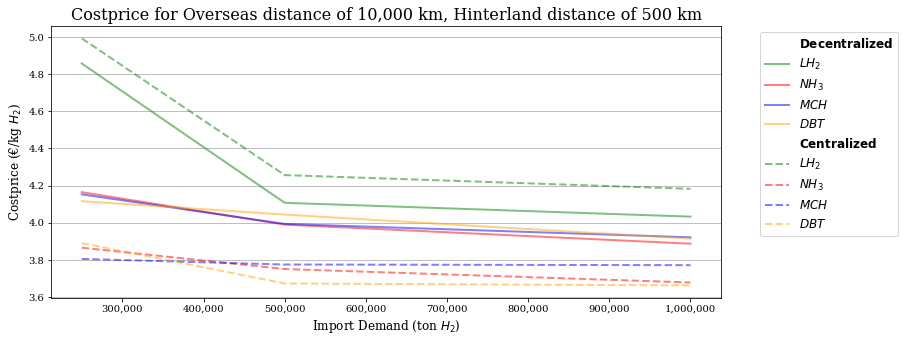

In [15]:
#new
volume = volume
x = volume

#with losses 0.5
NH3_tot_cen = list(save_costprice3[0])
NH3_tot_dec = list(save_costprice4[0])

DBT_tot_cen = list(save_costprice3[1])
DBT_tot_dec = list(save_costprice4[1])

MCH_tot_cen = list(save_costprice3[2])
MCH_tot_dec = list(save_costprice4[2])

LH2_tot_cen = list(save_costprice3[3])
LH2_tot_dec = list(save_costprice4[3])

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)

ax.plot([], [], ' ', label="$\\bf{Decentralized}$")
ax.plot(x, LH2_tot_dec, label = '$LH_2$', color = 'green',  alpha = 0.5, linewidth = 2)
ax.plot(x, NH3_tot_dec, label = '$NH_3$', color = 'red',  alpha = 0.5, linewidth = 2)
ax.plot(x, MCH_tot_dec, label = '$MCH$', color = 'blue',  alpha = 0.5, linewidth = 2)
ax.plot(x, DBT_tot_dec, label = '$DBT$', color = 'orange', alpha = 0.5, linewidth = 2)


ax.plot([], [], ' ', label="$\\bf{Centralized}$")
ax.plot(x, LH2_tot_cen , label = '$LH_2$', color = 'green',linestyle = 'dashed', alpha = 0.5, linewidth = 2)
ax.plot(x, NH3_tot_cen , label = '$NH_3$ ', color = 'red', linestyle = 'dashed', alpha = 0.5, linewidth = 2)
ax.plot(x, MCH_tot_cen, label = '$MCH$ ', color = 'blue', linestyle = 'dashed',alpha = 0.5, linewidth = 2)
ax.plot(x, DBT_tot_cen, label = '$DBT$', color = 'orange', linestyle = 'dashed',alpha = 0.5, linewidth = 2)

ax.set_ylabel('Costprice (€/kg $H_2$)', fontdict = font)
ax.set_xlabel('Import Demand (ton $H_2$)', fontdict = font)
ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left', prop = {'family':'serif', 'size':12})

for tick in ax.get_xticklabels():
    tick.set_fontname("serif")
for tick in ax.get_yticklabels():
    tick.set_fontname("serif")

ax.set_title('Costprice for Overseas distance of 10,000 km, Hinterland distance of 500 km',fontdict = font, fontsize = 16)
axes = plt.gca()
axes.yaxis.grid()
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


